# Análisis Exploratorio de Datos (EDA) – 30 Empresas Tecnológicas

Este notebook realiza un análisis inicial de los datos descargados de yfinance:
- Panel mensual de precios y retornos
- Estadísticas descriptivas
- Gráficos de tendencia y volatilidad

In [312]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.style.use("default")
sns.set_context("notebook")


In [313]:
# Rutas (asumiendo notebook en /notebooks)
PROJECT_ROOT = os.path.dirname(os.getcwd())
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")

PANEL_FILE = os.path.join(PROCESSED_DIR, "tech30_panel_monthly_2018_2024.csv")
AGG_FILE   = os.path.join(PROCESSED_DIR, "tech30_aggregated_stats_2018_2024.csv")

panel_df = pd.read_csv(PANEL_FILE, parse_dates=["Date"])
agg_df   = pd.read_csv(AGG_FILE)

panel_df.head()


,Company,Ticker,Date,AdjClose,Volume,Return
0,Microsoft,MSFT,2018-02-28,86.647766,725663300.0,-0.008451
1,Microsoft,MSFT,2018-03-31,84.337616,750754800.0,-0.027023
2,Microsoft,MSFT,2018-04-30,86.416756,668130700.0,0.024354
3,Microsoft,MSFT,2018-05-31,91.728539,509417900.0,0.059652
4,Microsoft,MSFT,2018-06-30,91.515099,602585200.0,-0.002330


In [314]:
print("Observaciones:", panel_df.shape[0])
print("Empresas:", panel_df["Company"].nunique())
print("Periodo:", panel_df["Date"].min().date(), "-", panel_df["Date"].max().date())


Observaciones: 2403
Empresas: 30
Periodo: 2018-02-28 - 2024-12-31


In [315]:
panel_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2403 entries, 0 to 2402
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Company   2403 non-null   object        
 1   Ticker    2403 non-null   object        
 2   Date      2403 non-null   datetime64[ns]
 3   AdjClose  2403 non-null   float64       
 4   Volume    2403 non-null   float64       
 5   Return    2403 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 112.8+ KB


In [316]:
panel_df[["AdjClose", "Volume", "Return"]].describe()


,AdjClose,Volume,Return
count,2403.000000,2.403000e+03,2403.000000
mean,2084.289002,8.409799e+08,0.015266
std,10555.088858,1.905822e+09,0.108431
min,3.309732,8.622200e+06,-0.676915
25%,44.554747,8.869875e+07,-0.045282
50%,113.000000,2.449590e+08,0.017335
75%,222.747810,6.783272e+08,0.075117
max,81511.546875,1.687099e+10,0.984401


In [317]:
panel_df.groupby("Company")["Return"].agg(
    MeanReturn="mean",
    StdReturn="std",
    MinReturn="min",
    MaxReturn="max",
    N="count"
).sort_values("MeanReturn", ascending=False)


,MeanReturn,StdReturn,MinReturn,MaxReturn,N
Company,,,,,
Palantir,0.041075,0.248074,-0.386599,0.984401,51
Nvidia,0.037576,0.140490,-0.386065,0.310008,83
Tesla,0.034602,0.189046,-0.457813,0.554719,83
Broadcom,0.029832,0.092371,-0.235309,0.376636,83
Fortinet,0.028135,0.109302,-0.255274,0.286250,83
Cloudflare,0.028096,0.183820,-0.430622,0.547277,63
ServiceNow,0.023737,0.078987,-0.152548,0.211654,83
Apple,0.022371,0.084030,-0.199913,0.196035,83
Taiwan Semiconductor,0.020067,0.093745,-0.189700,0.329046,83


## Análisis de Valores Faltantes

El análisis de datos faltantes (missing data) es un componente fundamental del análisis exploratorio de datos en series temporales financieras. La presencia de valores faltantes puede introducir sesgos en los estimadores estadísticos y afectar la validez de las inferencias realizadas.

**Causas comunes en datos financieros:**
- Días sin cotización debido a feriados bursátiles o suspensiones de trading
- Errores en la captura o transmisión de datos desde las fuentes
- Empresas que iniciaron cotización pública posterior al periodo de análisis (IPO timing)

**Marco teórico (Little & Rubin, 2002):**

La clasificación de mecanismos de datos faltantes establece tres categorías:

1. **MCAR** (Missing Completely At Random): La probabilidad de que un dato falte es independiente tanto de los valores observados como de los no observados.

2. **MAR** (Missing At Random): La probabilidad de que un dato falte depende únicamente de la información observada, no de los valores faltantes mismos.

3. **MNAR** (Missing Not At Random): La probabilidad de que un dato falte depende del valor no observado, lo que puede generar sesgo no ignorable.

**Referencia:** Little, R.J.A. & Rubin, D.B. (2002). *Statistical Analysis with Missing Data*. Wiley.

VALORES FALTANTES POR COLUMNA
Company     0
Ticker      0
Date        0
AdjClose    0
Volume      0
Return      0
dtype: int64

PORCENTAJE DE DATOS FALTANTES
Company     0.0
Ticker      0.0
Date        0.0
AdjClose    0.0
Volume      0.0
Return      0.0
dtype: float64

PATRÓN DE VALORES FALTANTES (ver gráfico)


<Figure size 1200x600 with 0 Axes>

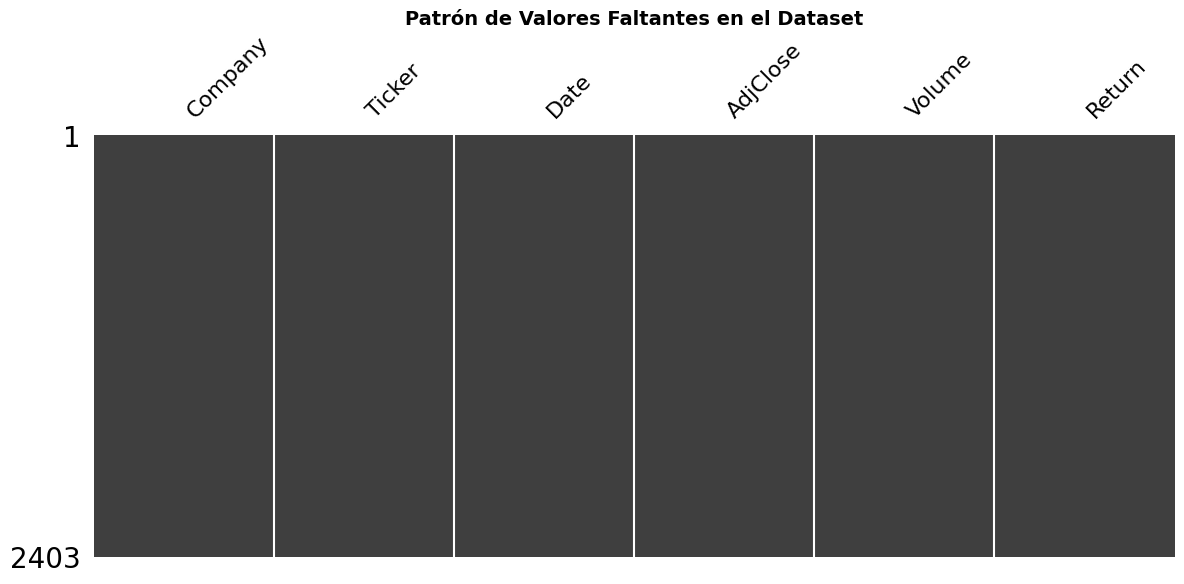


EMPRESAS CON MENOS OBSERVACIONES QUE EL MÁXIMO
Máximo de observaciones: 83

Empresas con datos incompletos:
Company
Palantir      51
Snowflake     51
Cloudflare    63
Spotify       80
dtype: int64


In [318]:
# ============================================
# Análisis de Valores Faltantes
# ============================================
import missingno as msno  # pip install missingno

# 1. Contar valores faltantes por columna
# .isnull() retorna True/False para cada celda
# .sum() cuenta los True (valores nulos)
missing_counts = panel_df.isnull().sum()
print("=" * 60)
print("VALORES FALTANTES POR COLUMNA")
print("=" * 60)
print(missing_counts)

# 2. Porcentaje de datos faltantes
# Dividimos entre el total de filas para obtener proporción
missing_pct = (panel_df.isnull().sum() / len(panel_df)) * 100
print("\n" + "=" * 60)
print("PORCENTAJE DE DATOS FALTANTES")
print("=" * 60)
print(missing_pct.round(2))

# 3. Visualización matricial de valores faltantes
# msno.matrix muestra patrones de datos faltantes
# Las líneas blancas indican valores nulos
print("\n" + "=" * 60)
print("PATRÓN DE VALORES FALTANTES (ver gráfico)")
print("=" * 60)

plt.figure(figsize=(12, 6))
msno.matrix(panel_df, figsize=(12, 6), sparkline=False)
plt.title("Patrón de Valores Faltantes en el Dataset", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../data/processed/missing_values_pattern.png", dpi=150)
plt.show()

# 4. Empresas con datos incompletos
# Agrupamos por empresa y contamos filas
obs_por_empresa = panel_df.groupby("Company").size()
empresas_incompletas = obs_por_empresa[obs_por_empresa < obs_por_empresa.max()]

print("\n" + "=" * 60)
print("EMPRESAS CON MENOS OBSERVACIONES QUE EL MÁXIMO")
print("=" * 60)
if len(empresas_incompletas) > 0:
    print(f"Máximo de observaciones: {obs_por_empresa.max()}")
    print("\nEmpresas con datos incompletos:")
    print(empresas_incompletas.sort_values())
else:
    print("Todas las empresas presentan el mismo numero de observaciones")
    print(f"  Total de observaciones por empresa: {obs_por_empresa.max()}")

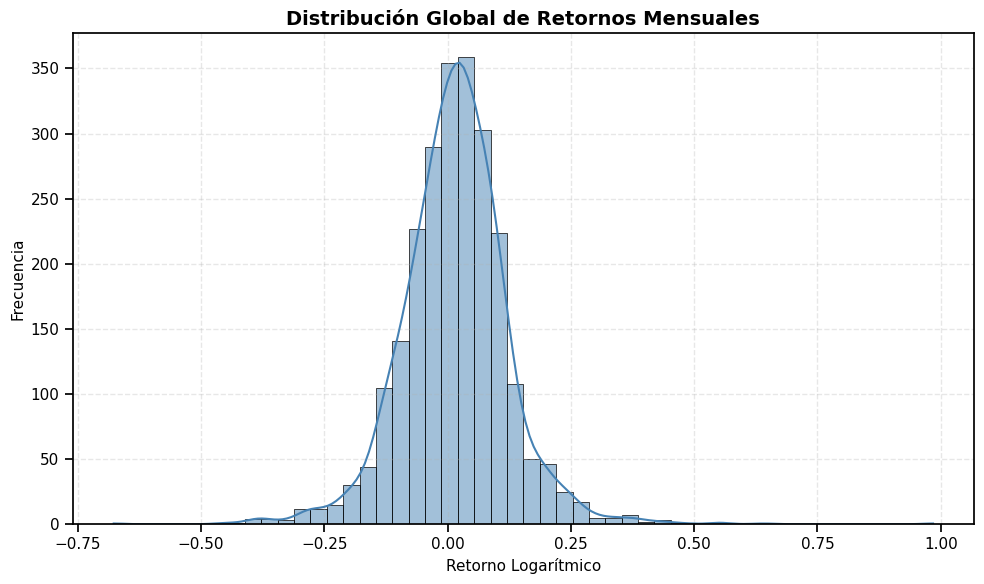

In [319]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(panel_df["Return"], bins=50, kde=True, ax=ax, color='steelblue', edgecolor='black', linewidth=0.5)
ax.set_title("Distribución Global de Retornos Mensuales", fontsize=14, fontweight='bold')
ax.set_xlabel("Retorno Logarítmico", fontsize=11)
ax.set_ylabel("Frecuencia", fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig("../data/processed/return_distribution.png", dpi=150, bbox_inches='tight')
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_20860\3606390529.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Company", y="Return", data=panel_df, ax=ax, palette="Set2")
C:\Users\admin\AppData\Local\Temp\ipykernel_20860\3606390529.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=9)


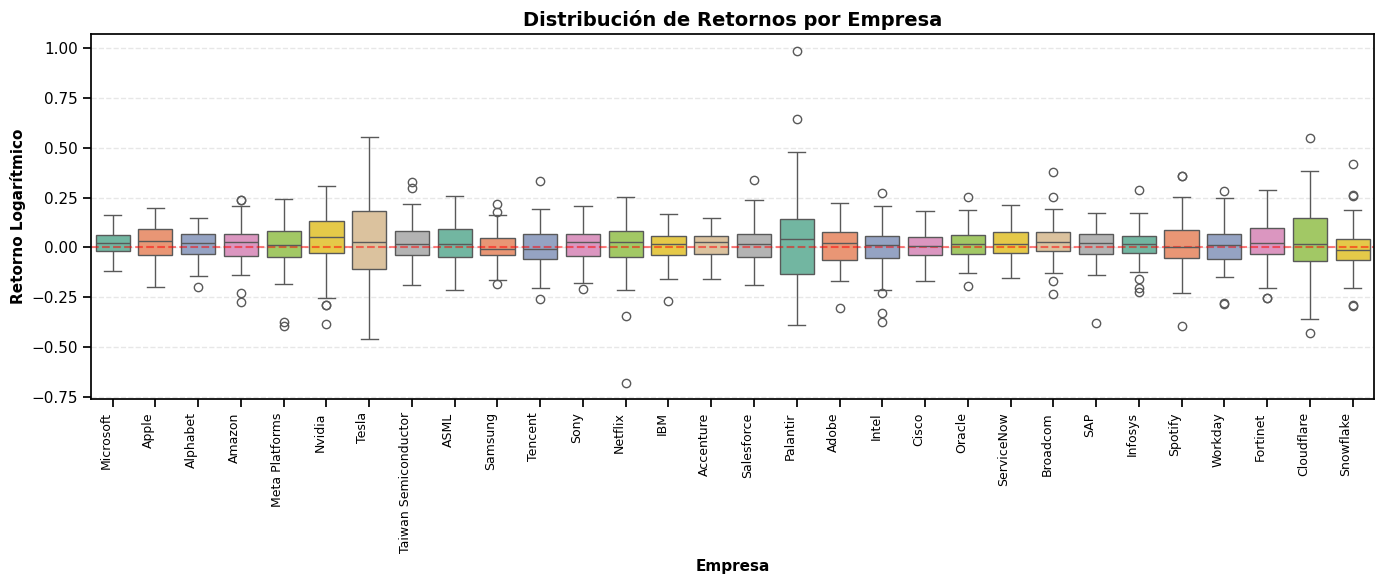

In [320]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(x="Company", y="Return", data=panel_df, ax=ax, palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=9)
ax.set_title("Distribución de Retornos por Empresa", fontsize=14, fontweight='bold')
ax.set_xlabel("Empresa", fontsize=11, fontweight='bold')
ax.set_ylabel("Retorno Logarítmico", fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
plt.tight_layout()
plt.savefig("../data/processed/returns_by_company.png", dpi=150, bbox_inches='tight')
plt.show()


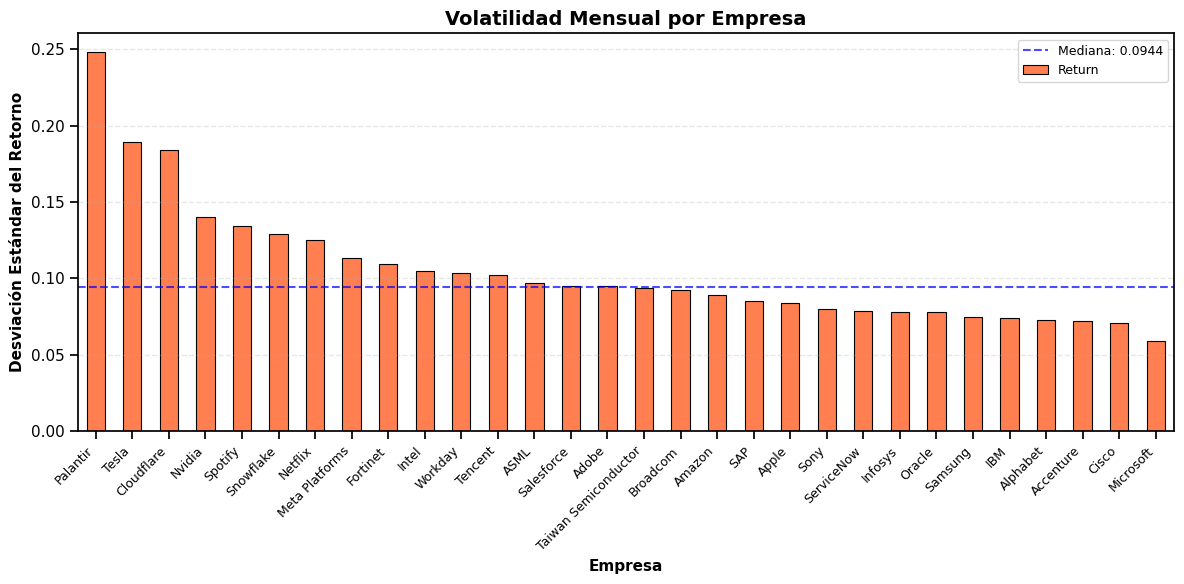

In [321]:
vol_df = panel_df.groupby("Company")["Return"].std().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
vol_df.plot(kind="bar", ax=ax, color='coral', edgecolor='black', linewidth=0.8)
ax.set_title("Volatilidad Mensual por Empresa", fontsize=14, fontweight='bold')
ax.set_xlabel("Empresa", fontsize=11, fontweight='bold')
ax.set_ylabel("Desviación Estándar del Retorno", fontsize=11, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.axhline(y=vol_df.median(), color='blue', linestyle='--', alpha=0.7, linewidth=1.5, label=f'Mediana: {vol_df.median():.4f}')
ax.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig("../data/processed/volatility_by_company.png", dpi=150, bbox_inches='tight')
plt.show()


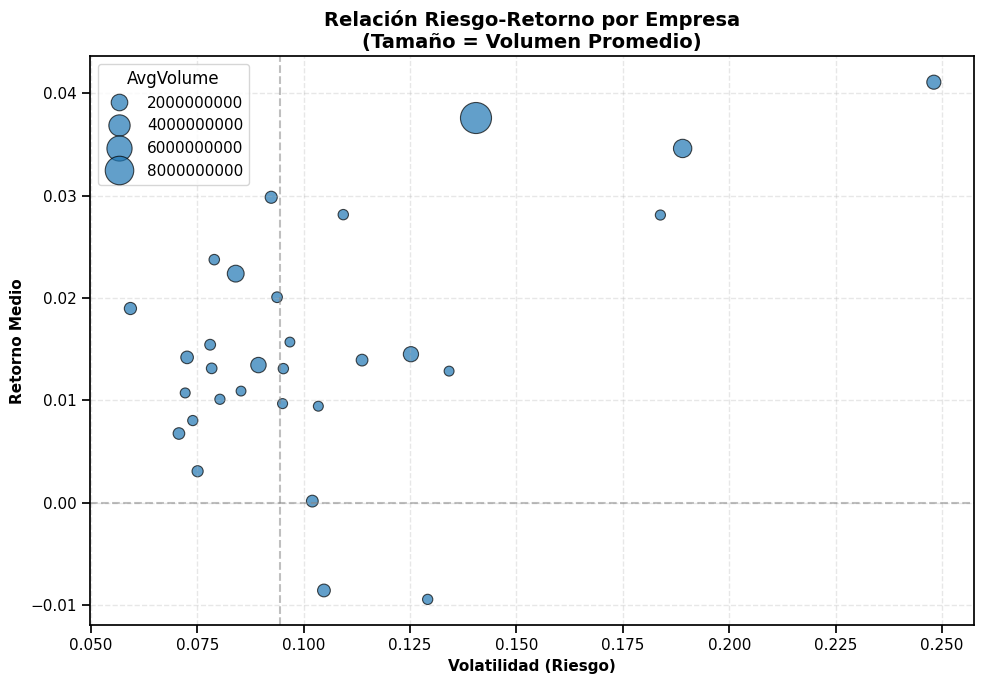

In [322]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(
    x=agg_df["Volatility"],
    y=agg_df["MeanReturn"],
    size=agg_df["AvgVolume"],
    sizes=(50, 500),
    alpha=0.7,
    ax=ax,
    edgecolor='black',
    linewidth=0.8
)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=agg_df["Volatility"].median(), color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel("Volatilidad (Riesgo)", fontsize=11, fontweight='bold')
ax.set_ylabel("Retorno Medio", fontsize=11, fontweight='bold')
ax.set_title("Relación Riesgo-Retorno por Empresa\n(Tamaño = Volumen Promedio)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig("../data/processed/risk_return_relation.png", dpi=150, bbox_inches='tight')
plt.show()


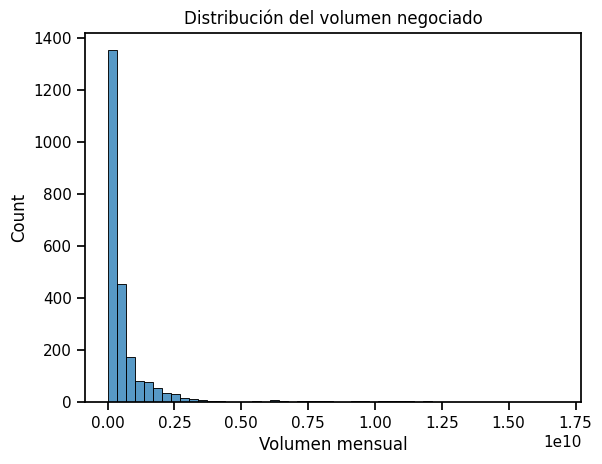

In [323]:
plt.figure()
sns.histplot(panel_df["Volume"], bins=50)
plt.title("Distribución del volumen negociado")
plt.xlabel("Volumen mensual")
plt.show()


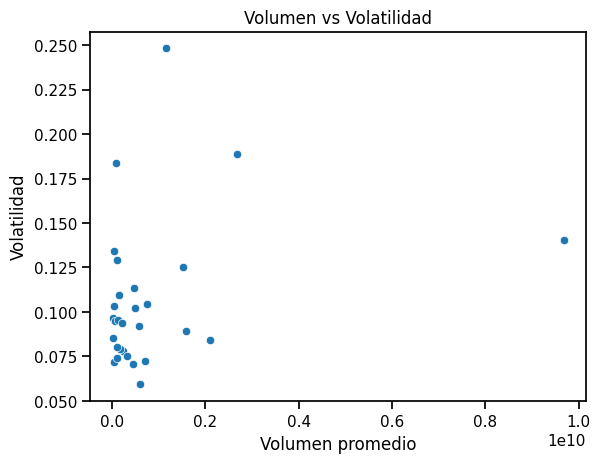

In [324]:
plt.figure()
sns.scatterplot(
    x=agg_df["AvgVolume"],
    y=agg_df["Volatility"]
)
plt.xlabel("Volumen promedio")
plt.ylabel("Volatilidad")
plt.title("Volumen vs Volatilidad")
plt.show()


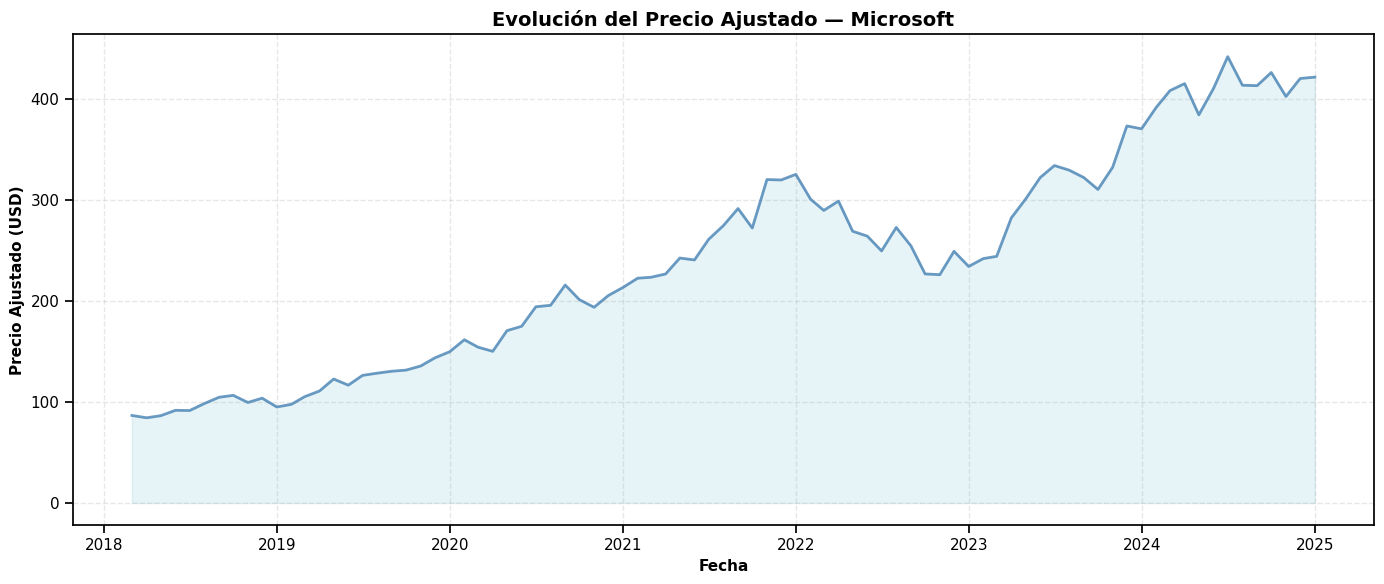

In [325]:
example_company = "Microsoft"
df_m = panel_df[panel_df["Company"] == example_company].sort_values("Date")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_m["Date"], df_m["AdjClose"], linewidth=2, color='steelblue', alpha=0.8)
ax.fill_between(df_m["Date"], df_m["AdjClose"], alpha=0.3, color='lightblue')
ax.set_title(f"Evolución del Precio Ajustado — {example_company}", fontsize=14, fontweight='bold')
ax.set_xlabel("Fecha", fontsize=11, fontweight='bold')
ax.set_ylabel("Precio Ajustado (USD)", fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(f"../data/processed/{example_company.lower()}_price_evolution.png", dpi=150, bbox_inches='tight')
plt.show()


In [326]:
panel_df[["AdjClose", "Volume", "Return"]].corr()


,AdjClose,Volume,Return
AdjClose,1.000000,-0.051441,-0.016502
Volume,-0.051441,1.000000,0.040826
Return,-0.016502,0.040826,1.000000


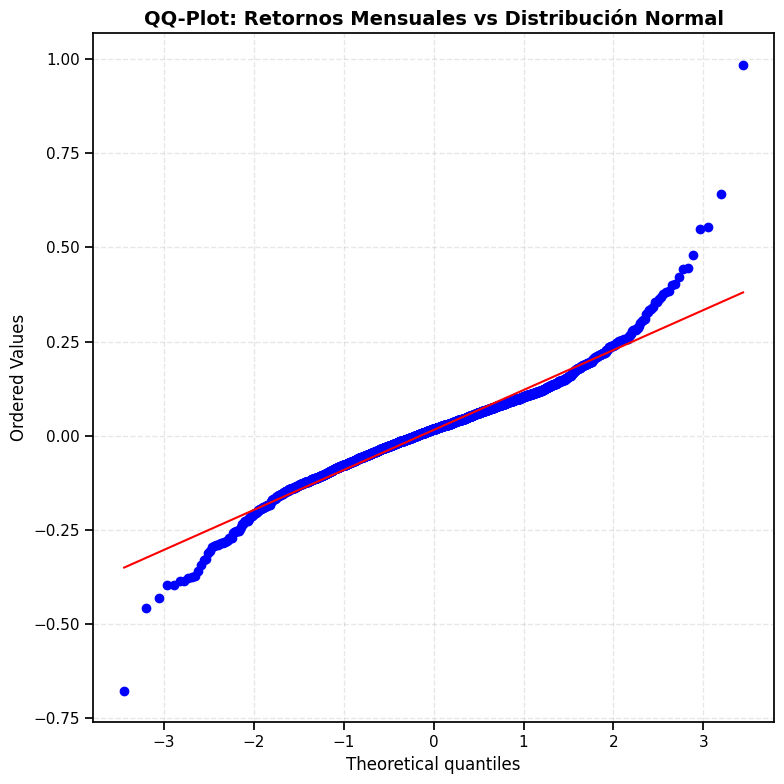

In [327]:
returns = panel_df["Return"].dropna()

fig, ax = plt.subplots(figsize=(8, 8))
stats.probplot(returns, dist="norm", plot=ax)
ax.set_title("QQ-Plot: Retornos Mensuales vs Distribución Normal", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig("../data/processed/qq_plot_returns.png", dpi=150, bbox_inches='tight')
plt.show()


In [328]:
# ============================================
# Detección de Outliers
# ============================================

# Método 1: Rango Intercuartílico (IQR)
# IQR = Q3 - Q1, outliers son valores fuera de [Q1-1.5*IQR, Q3+1.5*IQR]
def detectar_outliers_iqr(serie, factor=1.5):
    """
    Detecta outliers usando el método IQR (Tukey, 1977).
    
    Parámetros:
    -----------
    serie : pd.Series
        Serie de datos numéricos
    factor : float
        Multiplicador del IQR (1.5 es estándar, 3.0 para extremos)
    
    Retorna:
    --------
    pd.Series : booleano indicando si cada valor es outlier
    """
    Q1 = serie.quantile(0.25)  # Primer cuartil (percentil 25)
    Q3 = serie.quantile(0.75)  # Tercer cuartil (percentil 75)
    IQR = Q3 - Q1              # Rango intercuartílico
    
    # Límites inferior y superior
    limite_inf = Q1 - factor * IQR
    limite_sup = Q3 + factor * IQR
    
    # Retorna True si el valor está fuera de los límites
    return (serie < limite_inf) | (serie > limite_sup)

# Aplicar a los retornos
outliers_return = detectar_outliers_iqr(panel_df["Return"].dropna())
n_outliers = outliers_return.sum()
pct_outliers = (n_outliers / len(outliers_return)) * 100

print("=" * 60)
print("DETECCIÓN DE OUTLIERS - MÉTODO IQR")
print("=" * 60)
print(f"Outliers en retornos (método IQR):")
print(f"  Total: {n_outliers}")
print(f"  Porcentaje: {pct_outliers:.2f}%")

# Método 2: Z-score
# Un valor es outlier si |z| > 3 (está a más de 3 desv. estándar de la media)
z_scores = np.abs(stats.zscore(panel_df["Return"].dropna()))
outliers_zscore = z_scores > 3

print("\n" + "=" * 60)
print("DETECCIÓN DE OUTLIERS - Z-SCORE")
print("=" * 60)
print(f"Outliers en retornos (Z-score > 3):")
print(f"  Total: {outliers_zscore.sum()}")
print(f"  Porcentaje: {(outliers_zscore.sum() / len(outliers_zscore)) * 100:.2f}%")

# Identificar las observaciones más extremas
returns = panel_df["Return"].dropna()
Q1, Q3 = returns.quantile([0.25, 0.75])
IQR = Q3 - Q1
limite_inf = Q1 - 1.5*IQR
limite_sup = Q3 + 1.5*IQR

# Filtrar outliers para mostrar ejemplos
panel_with_index = panel_df[panel_df["Return"].notna()].copy()
panel_with_index['is_outlier'] = detectar_outliers_iqr(panel_with_index["Return"])
outliers_data = panel_with_index[panel_with_index['is_outlier']]

if len(outliers_data) > 0:
    print("\n" + "=" * 60)
    print("EJEMPLOS DE OUTLIERS MÁS EXTREMOS")
    print("=" * 60)
    top_outliers = outliers_data.nlargest(5, 'Return')[['Date', 'Company', 'Return']]
    bottom_outliers = outliers_data.nsmallest(5, 'Return')[['Date', 'Company', 'Return']]
    
    print("\nRetornos POSITIVOS más extremos:")
    print(top_outliers.to_string(index=False))
    
    print("\nRetornos NEGATIVOS más extremos:")
    print(bottom_outliers.to_string(index=False))

DETECCIÓN DE OUTLIERS - MÉTODO IQR
Outliers en retornos (método IQR):
  Total: 84
  Porcentaje: 3.50%

DETECCIÓN DE OUTLIERS - Z-SCORE
Outliers en retornos (Z-score > 3):
  Total: 33
  Porcentaje: 1.37%

EJEMPLOS DE OUTLIERS MÁS EXTREMOS

Retornos POSITIVOS más extremos:
      Date    Company   Return
2020-11-30   Palantir 0.984401
2023-05-31   Palantir 0.640835
2020-08-31      Tesla 0.554719
2021-10-31 Cloudflare 0.547277
2024-11-30   Palantir 0.478748

Retornos NEGATIVOS más extremos:
      Date        Company    Return
2022-04-30        Netflix -0.676915
2022-12-31          Tesla -0.457813
2022-05-31     Cloudflare -0.430622
2022-04-30        Spotify -0.395877
2022-02-28 Meta Platforms -0.395033


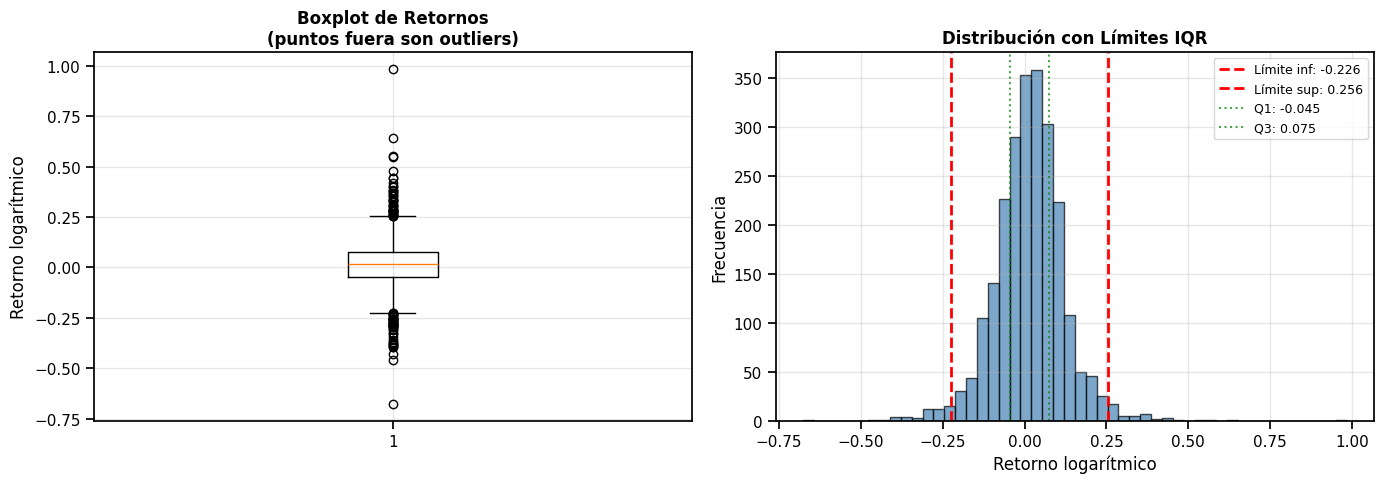

ESTADÍSTICAS DE LOS LÍMITES IQR
Q1 (Percentil 25):           -0.045282
Q3 (Percentil 75):           0.075117
IQR (Q3 - Q1):               0.120399
Límite Inferior (Q1-1.5*IQR): -0.225881
Límite Superior (Q3+1.5*IQR): 0.255717


In [329]:
# ============================================
# Visualización de Outliers
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot con outliers marcados
axes[0].boxplot(panel_df["Return"].dropna(), vert=True)
axes[0].set_title("Boxplot de Retornos\n(puntos fuera son outliers)", fontweight='bold')
axes[0].set_ylabel("Retorno logarítmico")
axes[0].grid(True, alpha=0.3)

# Histograma con líneas de corte IQR
returns = panel_df["Return"].dropna()
Q1, Q3 = returns.quantile([0.25, 0.75])
IQR = Q3 - Q1

axes[1].hist(returns, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(Q1 - 1.5*IQR, color='red', linestyle='--', linewidth=2,
                label=f'Límite inf: {Q1-1.5*IQR:.3f}')
axes[1].axvline(Q3 + 1.5*IQR, color='red', linestyle='--', linewidth=2,
                label=f'Límite sup: {Q3+1.5*IQR:.3f}')
axes[1].axvline(Q1, color='green', linestyle=':', alpha=0.7, label=f'Q1: {Q1:.3f}')
axes[1].axvline(Q3, color='green', linestyle=':', alpha=0.7, label=f'Q3: {Q3:.3f}')
axes[1].legend(fontsize=9)
axes[1].set_title("Distribución con Límites IQR", fontweight='bold')
axes[1].set_xlabel("Retorno logarítmico")
axes[1].set_ylabel("Frecuencia")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../data/processed/outliers_analysis.png", dpi=150)
plt.show()

# Información estadística
print("=" * 60)
print("ESTADÍSTICAS DE LOS LÍMITES IQR")
print("=" * 60)
print(f"Q1 (Percentil 25):           {Q1:.6f}")
print(f"Q3 (Percentil 75):           {Q3:.6f}")
print(f"IQR (Q3 - Q1):               {IQR:.6f}")
print(f"Límite Inferior (Q1-1.5*IQR): {Q1-1.5*IQR:.6f}")
print(f"Límite Superior (Q3+1.5*IQR): {Q3+1.5*IQR:.6f}")

## Detección de Valores Atípicos (Outliers)

La identificación de valores atípicos es esencial en el análisis de series temporales financieras, donde eventos extremos (e.g., crisis financieras, burbujas especulativas) representan información valiosa sobre el comportamiento del mercado.

**Métodos implementados:**

### 1. Método del Rango Intercuartílico (IQR)

Propuesto por Tukey (1977), define un outlier mediante:

```
x es outlier si: x < Q₁ - 1.5·IQR  o  x > Q₃ + 1.5·IQR
donde IQR = Q₃ - Q₁
```

**Ventajas:**
- Estimador robusto que no requiere supuestos distribucionales
- Resistente a la influencia de los propios valores atípicos
- Apropiado para distribuciones asimétricas (común en retornos financieros)

### 2. Método Z-Score

Basa la detección en desviaciones estándar:

```
z = (x - μ) / σ
x es outlier si: |z| > 3
```

**Limitaciones:**
- Asume distribución normal de los datos
- Los outliers afectan la media (μ) y desviación estándar (σ), reduciendo sensibilidad
- Menos apropiado para retornos financieros con colas pesadas

**Consideraciones en finanzas:**

En mercados financieros, los outliers frecuentemente corresponden a eventos económicos significativos y no deben ser eliminados automáticamente. Su análisis proporciona información sobre:
- Periodos de estrés de mercado
- Eventos de volatilidad extrema
- Respuesta a shocks macroeconómicos

**Referencias:**
- Tukey, J.W. (1977). *Exploratory Data Analysis*. Addison-Wesley.
- Barnett, V. & Lewis, T. (1994). *Outliers in Statistical Data*. Wiley.

## Análisis de Series Temporales Comparativas

El análisis comparativo de series temporales financieras permite evaluar el desempeño relativo de múltiples activos bajo un marco temporal común. La normalización de precios facilita la comparación visual de trayectorias de retorno independientemente de los niveles de precio absolutos.

**Características de series temporales financieras (Tsay, 2010):**

1. **No estacionariedad**: Los precios exhiben tendencias estocásticas (raíces unitarias), violando supuestos de estacionariedad requeridos por muchos modelos estadísticos clásicos.

2. **Volatility clustering**: Periodos de alta volatilidad tienden a agruparse temporalmente, fenómeno documentado por Mandelbrot (1963) y formalizado en modelos ARCH/GARCH.

3. **Distribuciones leptocúrticas**: Las innovaciones muestran colas más pesadas que la distribución normal, implicando mayor frecuencia de eventos extremos.

4. **Asimetría en shocks**: Los movimientos negativos (crashes) tienden a ser más abruptos que los movimientos positivos, fenómeno conocido como "efecto apalancamiento".

**Normalización de precios:**

La transformación a base 100 permite comparar rendimientos acumulados:

```
P_norm(t) = [P(t) / P(t₀)] × 100
```

donde P(t₀) es el precio en el periodo inicial. Esta métrica representa el valor de una inversión de 100 unidades monetarias en t₀.

**Referencia:** Tsay, R.S. (2010). *Analysis of Financial Time Series*. 3rd Edition. Wiley.

In [330]:
# ============================================
# Series Temporales Comparativas - Normalización a Base 100
# ============================================

# Selección de empresas representativas para análisis comparativo
# FAANG + empresas de alto crecimiento en el sector tecnológico
empresas_top = [
    "Apple", 
    "Microsoft", 
    "Alphabet", 
    "Amazon",
    "Meta Platforms", 
    "Nvidia", 
    "Tesla"
]

# Filtrar panel de datos para empresas seleccionadas
df_top = panel_df[panel_df["Company"].isin(empresas_top)].copy()

print("=" * 60)
print("EMPRESAS SELECCIONADAS PARA ANÁLISIS COMPARATIVO")
print("=" * 60)
print(f"Total de empresas: {len(empresas_top)}")
print(f"Observaciones totales: {len(df_top)}")
print(f"\nEmpresas: {', '.join(empresas_top)}")

# Reestructurar datos: pivotear para obtener precios por empresa en columnas
# Estructura resultante: índice = fechas, columnas = empresas, valores = precios
precios = df_top.pivot_table(
    index="Date",
    columns="Company",
    values="AdjClose"
)

print(f"\nDimensiones de matriz de precios:")
print(f"  Periodos temporales: {precios.shape[0]}")
print(f"  Empresas: {precios.shape[1]}")

# Normalización a base 100
# Formula: precio_normalizado(t) = [precio(t) / precio(t₀)] × 100
# Interpretación: valor de $100 invertidos en t₀
precios_norm = (precios / precios.iloc[0]) * 100

print("\n" + "=" * 60)
print("PRECIOS NORMALIZADOS (primeras 5 observaciones)")
print("=" * 60)
print(precios_norm.head())

EMPRESAS SELECCIONADAS PARA ANÁLISIS COMPARATIVO
Total de empresas: 7
Observaciones totales: 581

Empresas: Apple, Microsoft, Alphabet, Amazon, Meta Platforms, Nvidia, Tesla

Dimensiones de matriz de precios:
  Periodos temporales: 83
  Empresas: 7

PRECIOS NORMALIZADOS (primeras 5 observaciones)
Company       Alphabet      Amazon       Apple  Meta Platforms   Microsoft  \
Date                                                                         
2018-02-28  100.000000  100.000000  100.000000      100.000000  100.000000   
2018-03-31   93.950655   95.695063   94.194920       89.608561   97.333861   
2018-04-30   92.269376  103.549216   92.780131       96.455813   99.733391   
2018-05-31   99.644908  107.747040  105.316944      107.548232  105.863708   
2018-06-30  102.289128  112.387187  104.325016      108.972640  105.617378   

Company         Nvidia       Tesla  
Date                                
2018-02-28  100.000000  100.000000  
2018-03-31   95.698373   77.575354  
2018-04

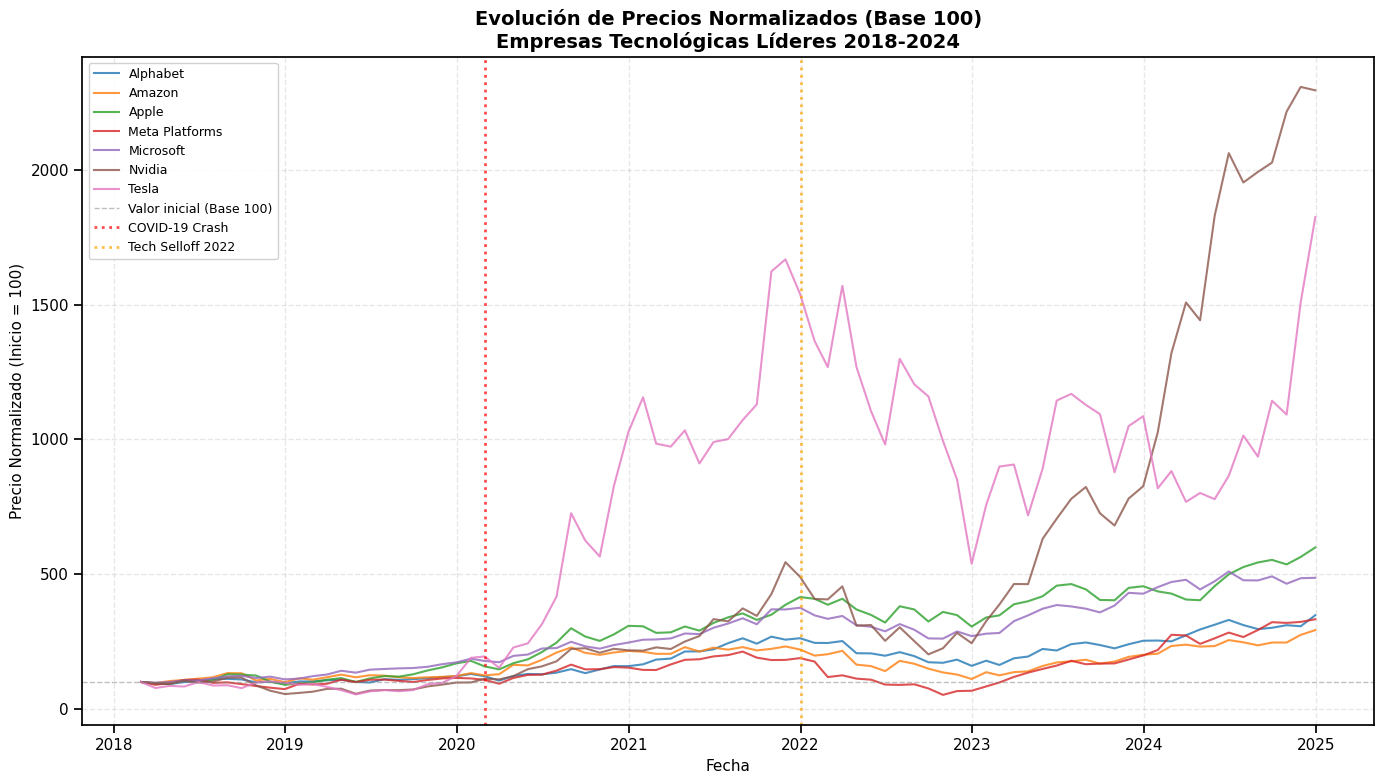

In [331]:
# ============================================
# Visualización de Series Temporales Normalizadas
# ============================================

plt.figure(figsize=(14, 8))

# Graficar cada serie temporal normalizada
for empresa in precios_norm.columns:
    plt.plot(
        precios_norm.index, 
        precios_norm[empresa],
        label=empresa, 
        linewidth=1.5,
        alpha=0.8
    )

# Línea de referencia en 100 (valor inicial)
plt.axhline(
    y=100, 
    color='gray', 
    linestyle='--', 
    alpha=0.5, 
    linewidth=1,
    label='Valor inicial (Base 100)'
)

# Marcadores de eventos macroeconómicos significativos
# COVID-19 crash: Marzo 2020
plt.axvline(
    pd.Timestamp('2020-03-01'), 
    color='red',
    linestyle=':', 
    alpha=0.7, 
    linewidth=2,
    label='COVID-19 Crash'
)

# Tech selloff: Inicio 2022 (política monetaria restrictiva)
plt.axvline(
    pd.Timestamp('2022-01-01'), 
    color='orange',
    linestyle=':', 
    alpha=0.7, 
    linewidth=2,
    label='Tech Selloff 2022'
)

# Configuración del gráfico
plt.title(
    "Evolución de Precios Normalizados (Base 100)\nEmpresas Tecnológicas Líderes 2018-2024",
    fontsize=14, 
    fontweight='bold'
)
plt.xlabel("Fecha", fontsize=11)
plt.ylabel("Precio Normalizado (Inicio = 100)", fontsize=11)
plt.legend(loc='upper left', fontsize=9, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Guardar gráfico
plt.savefig("../data/processed/series_normalizadas.png", dpi=150, bbox_inches='tight')
plt.show()

In [332]:
# ============================================
# Análisis de Rendimiento Total del Periodo
# ============================================

# Calcular rendimiento total acumulado
# Formula: R_total = [(P_final / P_inicial) - 1] × 100
rendimiento_total = ((precios.iloc[-1] / precios.iloc[0]) - 1) * 100

print("=" * 60)
print("RENDIMIENTO TOTAL DEL PERIODO (%)")
print("=" * 60)
print(f"Periodo analizado: {precios.index[0].strftime('%Y-%m-%d')} a {precios.index[-1].strftime('%Y-%m-%d')}")
print(f"Duración: {len(precios)} meses")
print("\n" + "-" * 60)

# Ordenar por rendimiento descendente
rendimientos_ordenados = rendimiento_total.sort_values(ascending=False)

for empresa, rendimiento in rendimientos_ordenados.items():
    print(f"{empresa:.<25} {rendimiento:>10.1f}%")

# Estadísticas del rendimiento
print("\n" + "=" * 60)
print("ESTADÍSTICAS DE RENDIMIENTO")
print("=" * 60)
print(f"Rendimiento promedio:        {rendimiento_total.mean():>10.1f}%")
print(f"Rendimiento mediano:         {rendimiento_total.median():>10.1f}%")
print(f"Desviación estándar:         {rendimiento_total.std():>10.1f}%")
print(f"Rendimiento máximo:          {rendimiento_total.max():>10.1f}% ({rendimiento_total.idxmax()})")
print(f"Rendimiento mínimo:          {rendimiento_total.min():>10.1f}% ({rendimiento_total.idxmin()})")

# Tasa de rendimiento anualizada (CAGR - Compound Annual Growth Rate)
# Formula: CAGR = [(Valor_final / Valor_inicial)^(1/años) - 1] × 100
n_years = len(precios) / 12  # Convertir meses a años
cagr = ((precios.iloc[-1] / precios.iloc[0]) ** (1/n_years) - 1) * 100

print("\n" + "=" * 60)
print("TASA DE CRECIMIENTO ANUAL COMPUESTA (CAGR)")


RENDIMIENTO TOTAL DEL PERIODO (%)
Periodo analizado: 2018-02-28 a 2024-12-31
Duración: 83 meses

------------------------------------------------------------
Nvidia...................     2196.0%
Tesla....................     1725.1%
Apple....................      499.4%
Microsoft................      386.7%
Alphabet.................      247.7%
Meta Platforms...........      232.8%
Amazon...................      192.6%

ESTADÍSTICAS DE RENDIMIENTO
Rendimiento promedio:             782.9%
Rendimiento mediano:              386.7%
Desviación estándar:              822.5%
Rendimiento máximo:              2196.0% (Nvidia)
Rendimiento mínimo:               192.6% (Amazon)

TASA DE CRECIMIENTO ANUAL COMPUESTA (CAGR)


In [333]:
print("=" * 60)
print(f"Periodo en años: {n_years:.2f}")
print("\n" + "-" * 60)

cagr_ordenado = cagr.sort_values(ascending=False)
for empresa, tasa in cagr_ordenado.items():
    print(f"{empresa:.<25} {tasa:>10.1f}% anual")

Periodo en años: 6.92

------------------------------------------------------------
Nvidia...................       57.3% anual
Tesla....................       52.2% anual
Apple....................       29.6% anual
Microsoft................       25.7% anual
Alphabet.................       19.7% anual
Meta Platforms...........       19.0% anual
Amazon...................       16.8% anual


## Matriz de Correlación entre Activos

La correlación entre activos es un concepto fundamental en la teoría moderna de portafolios. Mide la relación lineal entre los rendimientos de dos activos y es crucial para la construcción de carteras eficientes y la gestión de riesgo.

**Coeficiente de correlación de Pearson:**

La correlación entre dos activos i y j se define como:

```
ρ_ij = Cov(R_i, R_j) / (σ_i · σ_j)
```

donde:
- Cov(R_i, R_j) es la covarianza entre los retornos de los activos i y j
- σ_i y σ_j son las desviaciones estándar de los retornos

**Interpretación:**
- ρ = +1: Correlación positiva perfecta (los activos se mueven en la misma dirección)
- ρ = 0: Sin correlación lineal (movimientos independientes)
- ρ = -1: Correlación negativa perfecta (los activos se mueven en direcciones opuestas)

**Importancia en construcción de portafolios (Markowitz, 1952):**

La teoría moderna de portafolios establece que combinar activos con correlación menor a 1 reduce el riesgo total del portafolio. Para un portafolio de dos activos:

```
σ_p² = w₁²σ₁² + w₂²σ₂² + 2w₁w₂σ₁σ₂ρ₁₂
```

El beneficio de la diversificación aumenta cuando ρ₁₂ disminuye. Activos con baja o negativa correlación proporcionan mayor reducción de riesgo.

**Referencias:**
- Markowitz, H. (1952). "Portfolio Selection". *Journal of Finance*, 7(1), 77-91.
- Elton, E.J. & Gruber, M.J. (1997). *Modern Portfolio Theory and Investment Analysis*. Wiley.

In [334]:
# ============================================
# Matriz de Correlación entre Empresas
# ============================================

# Reestructurar panel de datos para análisis de correlación
# Transformación: formato largo → formato ancho (wide)
# Resultado: filas = fechas, columnas = empresas, valores = retornos
returns_wide = panel_df.pivot_table(
    index="Date",           # Índice temporal (fechas como filas)
    columns="Company",      # Empresas como columnas
    values="Return"         # Retornos logarítmicos como valores
)

print("=" * 60)
print("ESTRUCTURA DE DATOS PARA ANÁLISIS DE CORRELACIÓN")
print("=" * 60)
print(f"Dimensiones del DataFrame pivoteado:")
print(f"  Periodos temporales (filas): {returns_wide.shape[0]}")
print(f"  Empresas (columnas): {returns_wide.shape[1]}")
print(f"\nPrimeras observaciones:")
print(returns_wide.head())

# Calcular matriz de correlación de Pearson
# Método: correlación producto-momento de Pearson entre todas las columnas
# Resultado: matriz simétrica n×n donde n = número de empresas
corr_matrix = returns_wide.corr()

print("\n" + "=" * 60)
print("ESTADÍSTICAS DE LA MATRIZ DE CORRELACIÓN")
print("=" * 60)
print(f"Dimensiones: {corr_matrix.shape[0]} × {corr_matrix.shape[1]}")
print(f"Correlación promedio (excluyendo diagonal): {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean():.4f}")
print(f"Correlación mínima: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].min():.4f}")
print(f"Correlación máxima: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max():.4f}")

ESTRUCTURA DE DATOS PARA ANÁLISIS DE CORRELACIÓN
Dimensiones del DataFrame pivoteado:
  Periodos temporales (filas): 83
  Empresas (columnas): 30

Primeras observaciones:
Company         ASML  Accenture     Adobe  Alphabet    Amazon     Apple  \
Date                                                                      
2018-02-28 -0.038011   0.001927  0.045839 -0.068527  0.041554  0.065961   
2018-03-31  0.016094  -0.047766  0.032693 -0.062400 -0.044003 -0.059804   
2018-04-30 -0.043440  -0.006312  0.025225 -0.018057  0.078880 -0.015134   
2018-05-31  0.042593   0.029585  0.117703  0.076901  0.039739  0.126742   
2018-06-30  0.006690   0.049175 -0.022188  0.026190  0.042164 -0.009463   

Company     Broadcom     Cisco  Cloudflare  Fortinet  ...  Salesforce  \
Date                                                  ...               
2018-02-28 -0.006350  0.075105         NaN  0.091868  ...    0.020334   
2018-03-31 -0.030305 -0.043123         NaN  0.059797  ...    0.000430   
2018-04-30 

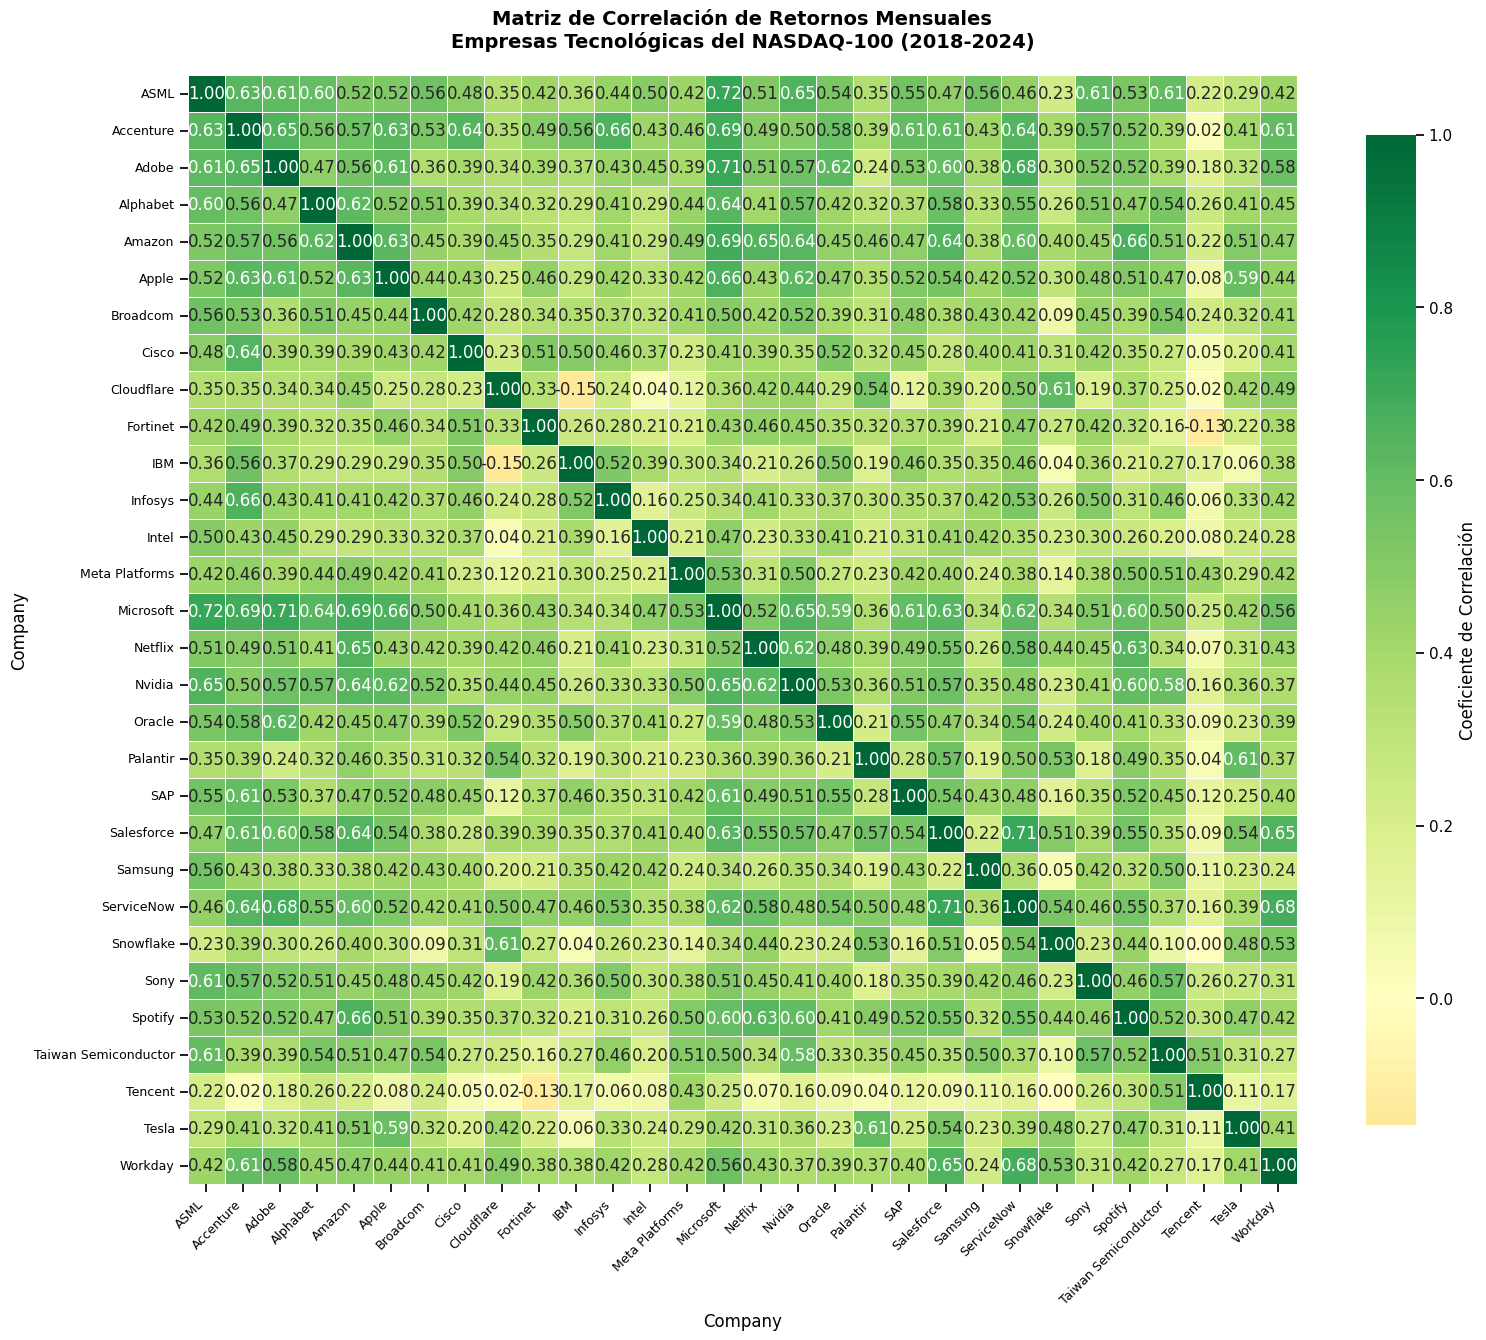

In [335]:
# ============================================
# Visualización: Heatmap de Correlación
# ============================================

plt.figure(figsize=(16, 14))

# Crear heatmap con seaborn
# annot=True: mostrar valores numéricos en cada celda
# fmt=".2f": formato de dos decimales
# cmap="RdYlGn": paleta rojo-amarillo-verde (rojo=baja, verde=alta correlación)
# center=0: centrar escala de colores en cero
sns.heatmap(
    corr_matrix,
    annot=True,              # Anotaciones numéricas en celdas
    fmt=".2f",               # Formato de dos decimales
    cmap="RdYlGn",           # Esquema de colores divergente
    center=0,                # Punto central de la escala de colores
    square=True,             # Celdas cuadradas para mejor visualización
    linewidths=0.5,          # Líneas separadoras entre celdas
    cbar_kws={"shrink": 0.8, "label": "Coeficiente de Correlación"}
)

plt.title(
    "Matriz de Correlación de Retornos Mensuales\nEmpresas Tecnológicas del NASDAQ-100 (2018-2024)",
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

# Guardar visualización
plt.savefig("../data/processed/correlation_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

In [336]:
# ============================================
# Análisis de Pares de Activos: Correlaciones Extremas
# ============================================

# Convertir matriz de correlación a formato largo
# Estrategia: extraer todos los pares únicos (i,j) donde i < j
corr_pairs = corr_matrix.unstack()  # Convertir matriz a Series con MultiIndex

# Filtrar para evitar duplicados y autocorrelaciones
# Condición: mantener solo pares donde índice de nivel 0 < índice de nivel 1
corr_pairs = corr_pairs[
    corr_pairs.index.get_level_values(0) < corr_pairs.index.get_level_values(1)
]

print("=" * 60)
print("PARES DE ACTIVOS CON MAYOR CORRELACIÓN")
print("=" * 60)
print("Interpretación: Alta correlación implica movimientos sincronizados")
print("Beneficio de diversificación limitado entre estos pares\n")

top_corr = corr_pairs.sort_values(ascending=False).head(10)
for idx, (pair, value) in enumerate(top_corr.items(), 1):
    print(f"{idx:2d}. {pair[0]:.<25} - {pair[1]:.<25} ρ = {value:.4f}")

print("\n" + "=" * 60)
print("PARES DE ACTIVOS CON MENOR CORRELACIÓN")
print("=" * 60)
print("Interpretación: Baja correlación implica movimientos independientes")
print("Mayor potencial de diversificación entre estos pares\n")

bottom_corr = corr_pairs.sort_values(ascending=True).head(10)
for idx, (pair, value) in enumerate(bottom_corr.items(), 1):
    print(f"{idx:2d}. {pair[0]:.<25} - {pair[1]:.<25} ρ = {value:.4f}")

# Distribución de correlaciones
print("\n" + "=" * 60)
print("DISTRIBUCIÓN DE CORRELACIONES")
print("=" * 60)
print(f"Total de pares únicos: {len(corr_pairs)}")
print(f"\nCuartiles:")
print(f"  Q1 (25%):  {corr_pairs.quantile(0.25):.4f}")
print(f"  Q2 (50%):  {corr_pairs.quantile(0.50):.4f}")
print(f"  Q3 (75%):  {corr_pairs.quantile(0.75):.4f}")

# Clasificación por nivel de correlación
high_corr = (corr_pairs >= 0.7).sum()
medium_corr = ((corr_pairs >= 0.4) & (corr_pairs < 0.7)).sum()
low_corr = (corr_pairs < 0.4).sum()

print(f"\nClasificación por intensidad:")
print(f"  Correlación alta (ρ ≥ 0.7):     {high_corr:3d} pares ({high_corr/len(corr_pairs)*100:.1f}%)")
print(f"  Correlación media (0.4 ≤ ρ < 0.7): {medium_corr:3d} pares ({medium_corr/len(corr_pairs)*100:.1f}%)")
print(f"  Correlación baja (ρ < 0.4):     {low_corr:3d} pares ({low_corr/len(corr_pairs)*100:.1f}%)")

PARES DE ACTIVOS CON MAYOR CORRELACIÓN
Interpretación: Alta correlación implica movimientos sincronizados
Beneficio de diversificación limitado entre estos pares

 1. ASML..................... - Microsoft................ ρ = 0.7211
 2. Salesforce............... - ServiceNow............... ρ = 0.7112
 3. Adobe.................... - Microsoft................ ρ = 0.7094
 4. Amazon................... - Microsoft................ ρ = 0.6899
 5. Accenture................ - Microsoft................ ρ = 0.6884
 6. Adobe.................... - ServiceNow............... ρ = 0.6845
 7. ServiceNow............... - Workday.................. ρ = 0.6832
 8. Apple.................... - Microsoft................ ρ = 0.6626
 9. Accenture................ - Infosys.................. ρ = 0.6572
10. Amazon................... - Spotify.................. ρ = 0.6554

PARES DE ACTIVOS CON MENOR CORRELACIÓN
Interpretación: Baja correlación implica movimientos independientes
Mayor potencial de diversificación entr

## Análisis Detallado de Distribución: Momentos Estadísticos

El análisis de los momentos estadísticos permite caracterizar completamente la distribución de retornos financieros, identificando desviaciones respecto a la distribución normal que tienen implicaciones directas para modelos de valoración de activos y gestión de riesgo.

**Momentos de una Distribución**

Una distribución de probabilidad se caracteriza por sus momentos:

1. **Media (primer momento):** $\mu = E[X]$
   - Medida de tendencia central
   - Representa el retorno esperado del activo

2. **Varianza (segundo momento):** $\sigma^2 = E[(X-\mu)^2]$
   - Medida de dispersión
   - Cuantifica el riesgo total del activo

3. **Asimetría o Skewness (tercer momento normalizado):**

$$
\gamma_1 = E\left[\left(\frac{X-\mu}{\sigma}\right)^3\right]
$$

   - $\gamma_1 = 0$: Distribución simétrica (como la normal)
   - $\gamma_1 > 0$: Cola derecha más larga (sesgo positivo) — mayor probabilidad de retornos extremos positivos
   - $\gamma_1 < 0$: Cola izquierda más larga (sesgo negativo) — mayor probabilidad de pérdidas extremas

4. **Curtosis (cuarto momento normalizado):**

$$
\gamma_2 = E\left[\left(\frac{X-\mu}{\sigma}\right)^4\right] - 3
$$

   - $\gamma_2 = 0$: Curtosis igual a la distribución normal (mesocúrtica)
   - $\gamma_2 > 0$: Colas más pesadas que la normal (leptocúrtica) — mayor frecuencia de eventos extremos
   - $\gamma_2 < 0$: Colas más livianas que la normal (platicúrtica) — menor frecuencia de eventos extremos

**Propiedades de Retornos Financieros**

Los retornos de activos financieros típicamente exhiben:

1. **Exceso de curtosis** $(\gamma_2 > 0)$: Implica más eventos extremos de lo esperado bajo normalidad (fat tails), con implicaciones críticas para:
   - Modelos de Value at Risk (VaR)
   - Cálculo de primas de riesgo
   - Estrategias de cobertura

2. **Asimetría negativa en índices**, pero variable en acciones individuales: Refleja que las caídas bruscas (crashes) son más comunes que alzas equivalentes.

**Test de Jarque-Bera**

El test de Jarque-Bera (1980) evalúa la hipótesis nula de normalidad mediante:

$$
JB = \frac{n}{6}\left[S^2 + \frac{(K-3)^2}{4}\right]
$$

donde $S$ es la asimetría (skewness), $K$ es la curtosis, y $n$ es el tamaño muestral.

Bajo $H_0$ (normalidad), $JB \sim \chi^2(2)$.

**Criterio de decisión:**
- Si $p < 0.05$: Rechazamos la hipótesis de normalidad al 5% de significancia
- Si $p \geq 0.05$: No hay evidencia suficiente para rechazar normalidad

**Implicaciones financieras:** La violación de normalidad invalida los supuestos de modelos clásicos como CAPM en su formulación básica y requiere el uso de distribuciones alternativas (t-Student, distribuciones estables) o modelos no paramétricos.

**Referencias:**
- Jarque, C.M. & Bera, A.K. (1980). "Efficient tests for normality, homoscedasticity and serial independence of regression residuals". *Economics Letters*, 6(3), 255-259.
- Mandelbrot, B. (1963). "The variation of certain speculative prices". *Journal of Business*, 36(4), 394-419.
- Fama, E.F. (1965). "The behavior of stock-market prices". *Journal of Business*, 38(1), 34-105.

In [337]:
# ============================================
# Análisis de Asimetría y Curtosis por Empresa
# ============================================
from scipy.stats import skew, kurtosis, jarque_bera

# Calcular momentos estadísticos para cada empresa
# Estrategia: iterar sobre empresas y calcular estadísticos de distribución
moments_list = []

for company in panel_df["Company"].unique():
    # Extraer retornos de la empresa actual
    # dropna() elimina valores faltantes para cálculo preciso
    returns = panel_df[panel_df["Company"] == company]["Return"].dropna()
    
    # Calcular estadísticos de forma:
    # - skew(): asimetría (tercer momento estandarizado)
    # - kurtosis(): exceso de curtosis (cuarto momento - 3)
    #   scipy.stats.kurtosis calcula "excess kurtosis" por defecto
    # - jarque_bera(): test de normalidad basado en S y K
    jb_stat, jb_pval = jarque_bera(returns)
    
    moments_list.append({
        "Company": company,
        "N": len(returns),                    # Tamaño muestral
        "Mean": returns.mean(),               # Retorno medio
        "Std": returns.std(),                 # Volatilidad (desv. estándar)
        "Skewness": skew(returns),            # Asimetría
        "Kurtosis": kurtosis(returns),        # Exceso de curtosis
        "JB_stat": jb_stat,                   # Estadístico de Jarque-Bera
        "JB_pval": jb_pval,                   # p-valor del test
        "Normal": "Sí" if jb_pval > 0.05 else "No"  # Decisión al 5%
    })

# Convertir lista de diccionarios a DataFrame
moments_df = pd.DataFrame(moments_list)

# Ordenar por curtosis descendente (empresas con colas más pesadas primero)
moments_df = moments_df.sort_values("Kurtosis", ascending=False)

print("=" * 80)
print("ANÁLISIS DE MOMENTOS ESTADÍSTICOS POR EMPRESA")
print("=" * 80)
print(f"Interpretación de columnas:")
print(f"  - Skewness > 0: Sesgo positivo (cola derecha más larga)")
print(f"  - Skewness < 0: Sesgo negativo (cola izquierda más larga)")
print(f"  - Kurtosis > 0: Colas más pesadas que la normal (leptocúrtica)")
print(f"  - JB_pval < 0.05: Se rechaza normalidad al 5% de significancia")
print("\n" + "-" * 80)
print(moments_df.to_string(index=False))

# Resumen estadístico del conjunto
print("\n" + "=" * 80)
print("ESTADÍSTICAS AGREGADAS DE LOS MOMENTOS")
print("=" * 80)
print(f"Asimetría promedio:          {moments_df['Skewness'].mean():>10.4f}")
print(f"Curtosis promedio:           {moments_df['Kurtosis'].mean():>10.4f}")
print(f"Empresas con distribución normal (5%): {(moments_df['Normal'] == 'Sí').sum()} de {len(moments_df)}")
print(f"Porcentaje de normalidad:    {(moments_df['Normal'] == 'Sí').sum() / len(moments_df) * 100:.1f}%")

# Clasificación por tipo de distribución
leptocurtica = (moments_df['Kurtosis'] > 0).sum()
mesocurtica = (moments_df['Kurtosis'].abs() <= 0.5).sum()
platicurtica = (moments_df['Kurtosis'] < -0.5).sum()

print("\n" + "=" * 80)
print("CLASIFICACIÓN POR CURTOSIS")
print("=" * 80)
print(f"Leptocúrticas (K > 0):       {leptocurtica:3d} empresas ({leptocurtica/len(moments_df)*100:.1f}%)")
print(f"Mesocúrticas (|K| ≤ 0.5):    {mesocurtica:3d} empresas ({mesocurtica/len(moments_df)*100:.1f}%)")
print(f"Platicúrticas (K < -0.5):    {platicurtica:3d} empresas ({platicurtica/len(moments_df)*100:.1f}%)")

# Clasificación por asimetría
sesgo_positivo = (moments_df['Skewness'] > 0.5).sum()
simetrica = (moments_df['Skewness'].abs() <= 0.5).sum()
sesgo_negativo = (moments_df['Skewness'] < -0.5).sum()

print("\n" + "=" * 80)
print("CLASIFICACIÓN POR ASIMETRÍA")
print("=" * 80)
print(f"Sesgo positivo (S > 0.5):    {sesgo_positivo:3d} empresas ({sesgo_positivo/len(moments_df)*100:.1f}%)")
print(f"Aproximadamente simétricas:  {simetrica:3d} empresas ({simetrica/len(moments_df)*100:.1f}%)")
print(f"Sesgo negativo (S < -0.5):   {sesgo_negativo:3d} empresas ({sesgo_negativo/len(moments_df)*100:.1f}%)")

ANÁLISIS DE MOMENTOS ESTADÍSTICOS POR EMPRESA
Interpretación de columnas:
  - Skewness > 0: Sesgo positivo (cola derecha más larga)
  - Skewness < 0: Sesgo negativo (cola izquierda más larga)
  - Kurtosis > 0: Colas más pesadas que la normal (leptocúrtica)
  - JB_pval < 0.05: Se rechaza normalidad al 5% de significancia

--------------------------------------------------------------------------------
             Company  N      Mean      Std  Skewness  Kurtosis    JB_stat      JB_pval Normal
             Netflix 83  0.014498 0.125202 -2.191313 10.157363 423.228857 1.250321e-92     No
                 SAP 83  0.010897 0.085278 -1.068418  3.629305  61.343647 4.779652e-14     No
            Palantir 51  0.041075 0.248074  1.304790  2.967102  33.178903 6.241555e-08     No
      Meta Platforms 83  0.013922 0.113717 -0.781011  2.177797  24.840211 4.036609e-06     No
            Broadcom 83  0.029832 0.092371  0.355443  2.108482  17.122402 1.913893e-04     No
             Infosys 83  0.01311

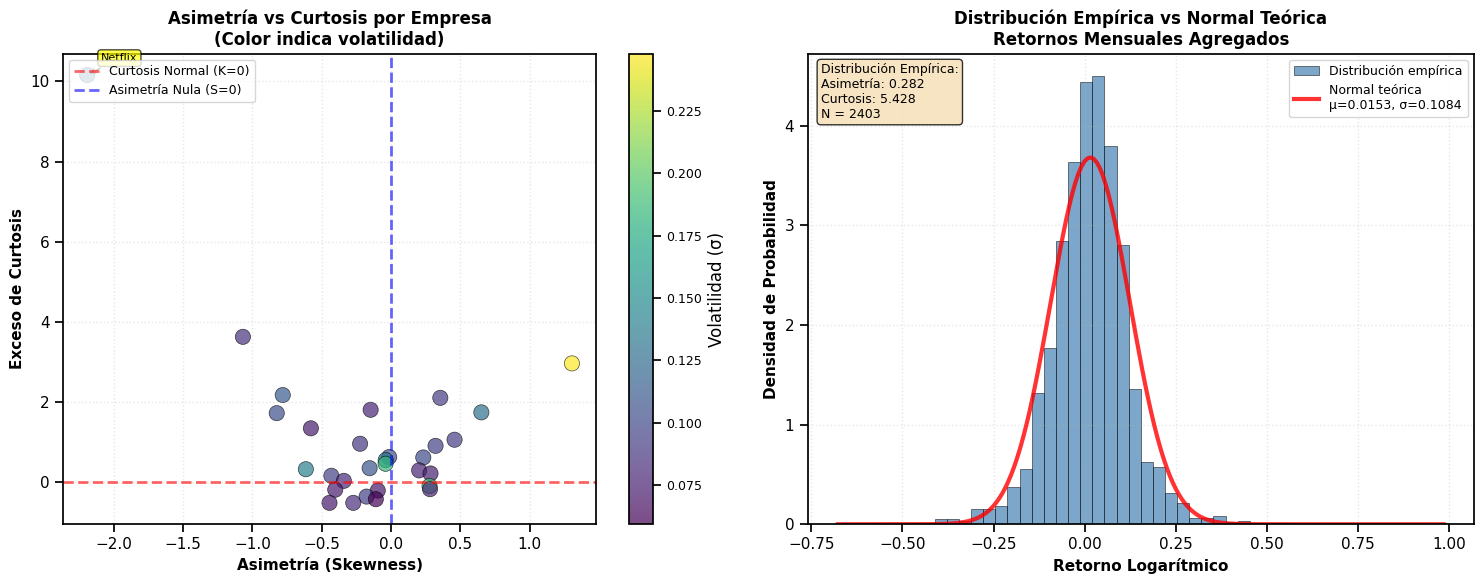

INTERPRETACIÓN DE VISUALIZACIONES

Panel Izquierdo (Skewness vs Kurtosis):
  - Puntos en cuadrante superior derecho: sesgo positivo y colas pesadas
  - Puntos alejados del origen: mayores desviaciones de normalidad
  - Color más intenso (amarillo): mayor volatilidad

Panel Derecho (Distribución vs Normal):
  - Barras azules más altas que curva roja en el centro: pico leptocúrtico
  - Barras azules en extremos: colas más pesadas que la normal
  - Asimetría visible si distribución no es simétrica respecto a la media


In [338]:
# ============================================
# Visualización: Asimetría vs Curtosis
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: Gráfico de dispersión Skewness vs Kurtosis
# El color representa la volatilidad (desv. estándar)
scatter = axes[0].scatter(
    moments_df["Skewness"],
    moments_df["Kurtosis"],
    c=moments_df["Std"],        # Color según volatilidad
    s=120,                       # Tamaño de puntos
    cmap="viridis",              # Paleta de colores
    alpha=0.7,                   # Transparencia
    edgecolors='black',          # Borde de puntos
    linewidth=0.5
)

# Líneas de referencia para distribución normal
axes[0].axhline(
    y=0, 
    color='red', 
    linestyle='--', 
    alpha=0.6, 
    linewidth=2,
    label='Curtosis Normal (K=0)'
)
axes[0].axvline(
    x=0, 
    color='blue', 
    linestyle='--', 
    alpha=0.6, 
    linewidth=2,
    label='Asimetría Nula (S=0)'
)

# Anotar empresas con características extremas
# Identificar empresa con mayor curtosis
max_kurt_idx = moments_df['Kurtosis'].idxmax()
max_kurt_company = moments_df.loc[max_kurt_idx, 'Company']
max_kurt_s = moments_df.loc[max_kurt_idx, 'Skewness']
max_kurt_k = moments_df.loc[max_kurt_idx, 'Kurtosis']

axes[0].annotate(
    max_kurt_company,
    xy=(max_kurt_s, max_kurt_k),
    xytext=(10, 10),
    textcoords='offset points',
    fontsize=8,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1)
)

axes[0].set_xlabel("Asimetría (Skewness)", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Exceso de Curtosis", fontsize=11, fontweight='bold')
axes[0].set_title("Asimetría vs Curtosis por Empresa\n(Color indica volatilidad)", 
                  fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3, linestyle=':')

# Barra de color para volatilidad
cbar = plt.colorbar(scatter, ax=axes[0], label="Volatilidad (σ)")
cbar.ax.tick_params(labelsize=9)

# Panel 2: Distribución empírica vs distribución normal teórica
# Calcular distribución de todos los retornos
returns_all = panel_df["Return"].dropna()
mean_ret = returns_all.mean()
std_ret = returns_all.std()

# Generar curva normal teórica
x = np.linspace(returns_all.min(), returns_all.max(), 200)
normal_pdf = stats.norm.pdf(x, mean_ret, std_ret)

# Histograma de datos reales (normalizado a densidad)
axes[1].hist(
    returns_all, 
    bins=50, 
    density=True,      # Normalizar a densidad de probabilidad
    alpha=0.7,
    label="Distribución empírica",
    edgecolor='black',
    linewidth=0.5,
    color='steelblue'
)

# Curva normal teórica superpuesta
axes[1].plot(
    x, 
    normal_pdf, 
    'r-', 
    linewidth=3, 
    label=f"Normal teórica\nμ={mean_ret:.4f}, σ={std_ret:.4f}",
    alpha=0.8
)

# Estadísticos de la distribución empírica
emp_skew = skew(returns_all)
emp_kurt = kurtosis(returns_all)

# Añadir texto con estadísticos
textstr = f'Distribución Empírica:\n'
textstr += f'Asimetría: {emp_skew:.3f}\n'
textstr += f'Curtosis: {emp_kurt:.3f}\n'
textstr += f'N = {len(returns_all)}'

axes[1].text(
    0.02, 0.98, 
    textstr,
    transform=axes[1].transAxes,
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
)

axes[1].set_xlabel("Retorno Logarítmico", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Densidad de Probabilidad", fontsize=11, fontweight='bold')
axes[1].set_title("Distribución Empírica vs Normal Teórica\nRetornos Mensuales Agregados", 
                  fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig("../data/processed/distribution_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

# Interpretación visual
print("=" * 80)
print("INTERPRETACIÓN DE VISUALIZACIONES")
print("=" * 80)
print("\nPanel Izquierdo (Skewness vs Kurtosis):")
print("  - Puntos en cuadrante superior derecho: sesgo positivo y colas pesadas")
print("  - Puntos alejados del origen: mayores desviaciones de normalidad")
print("  - Color más intenso (amarillo): mayor volatilidad")
print("\nPanel Derecho (Distribución vs Normal):")
print("  - Barras azules más altas que curva roja en el centro: pico leptocúrtico")
print("  - Barras azules en extremos: colas más pesadas que la normal")
print("  - Asimetría visible si distribución no es simétrica respecto a la media")

## Análisis de Drawdown (Caídas Máximas)

El análisis de drawdown es una métrica fundamental en la gestión de riesgo financiero que mide la magnitud de las pérdidas desde un máximo histórico. A diferencia de la volatilidad que captura la dispersión general de retornos, el drawdown cuantifica específicamente la severidad de las caídas sostenidas en el valor de un activo.

**Definiciones Fundamentales**

### Drawdown en el Tiempo t

El drawdown en el momento $t$ mide la caída porcentual desde el máximo histórico alcanzado hasta ese punto:

$$
DD_t = \frac{P_t - \max_{s \leq t} P_s}{\max_{s \leq t} P_s}
$$

donde:
- $P_t$ es el precio del activo en el momento $t$
- $\max_{s \leq t} P_s$ es el precio máximo observado hasta el momento $t$ (running maximum)
- $DD_t \leq 0$ por construcción (valores negativos indican caída, 0 indica nuevo máximo)

### Maximum Drawdown (MDD)

El Maximum Drawdown es el valor más negativo de toda la serie de drawdowns:

$$
MDD = \min_{t} DD_t = \min_{t} \left( \frac{P_t - \max_{s \leq t} P_s}{\max_{s \leq t} P_s} \right)
$$

Esta métrica representa la **peor caída histórica** que experimentó el activo desde cualquier pico anterior.

### Métricas Complementarias

1. **Time Underwater (Tiempo Bajo el Agua):**
   - Número de periodos en los que el activo cotiza por debajo de su máximo histórico
   - Refleja la persistencia de las pérdidas

2. **Recovery Time (Tiempo de Recuperación):**
   - Tiempo requerido para que el precio regrese al nivel del máximo previo
   - Indica la capacidad de recuperación del activo

3. **Average Drawdown:**
   - Promedio de todos los drawdowns observados
   - Proporciona una medida de la severidad típica de las caídas

**Importancia en Gestión de Riesgo**

El drawdown es crítico para:

1. **Evaluación del peor escenario histórico:** Permite conocer las pérdidas máximas que un inversor hubiera experimentado en el pasado.

2. **Planificación de capital:** Determina el colchón de liquidez necesario para soportar caídas sin liquidar posiciones.

3. **Comparación de activos:** Dos activos con igual retorno medio pueden tener MDD muy diferentes, afectando la experiencia del inversor.

4. **Asimetría de recuperación:** Si un activo cae 50%, requiere subir 100% para recuperar el nivel inicial:
   $$\frac{P_{final}}{P_{inicial} \times 0.5} = 2 \implies \text{Retorno requerido} = 100\%$$

5. **Psicología del inversor:** El MDD es un proxy del dolor máximo experimentado por inversores, crucial para evaluar tolerancia al riesgo.

**Limitaciones del Análisis**

1. **Dependencia del periodo:** El MDD calculado depende de la ventana temporal analizada.

2. **No captura frecuencia:** No diferencia entre una caída única de 50% y múltiples caídas de 25%.

3. **Optimismo histórico:** El MDD histórico no garantiza protección contra eventos futuros más severos.

**Referencias:**

- Magdon-Ismail, M. & Atiya, A. (2004). "Maximum Drawdown". *Risk Magazine*, 17(10), 99-102.
- Chekhlov, A., Uryasev, S. & Zabarankin, M. (2005). "Drawdown Measure in Portfolio Optimization". *International Journal of Theoretical and Applied Finance*, 8(1), 13-58.
- Calmar, T.W. (1991). Calmar Ratio: A smoother tool. *Futures*, 20(1), 40.

In [339]:
# ============================================
# Cálculo de Drawdown por Empresa
# ============================================

def calcular_drawdown(precios):
    """
    Calcula la serie temporal de drawdown para una serie de precios.
    
    El drawdown en cada momento t es la diferencia porcentual entre el precio
    actual y el máximo precio alcanzado hasta ese momento.
    
    Parámetros:
    -----------
    precios : pd.Series
        Serie temporal de precios del activo
    
    Retorna:
    --------
    pd.Series : 
        Serie de drawdowns (valores ≤ 0)
        - 0 indica que el precio está en máximo histórico
        - Valores negativos indican porcentaje de caída desde el máximo
    
    Ejemplo:
    --------
    Si el máximo histórico es $100 y el precio actual es $80:
    drawdown = (80 - 100) / 100 = -0.20 = -20%
    """
    # Eliminar valores NaN para cálculo robusto
    precios_clean = precios.dropna()
    
    # cummax() calcula el máximo acumulado (running maximum)
    # En cada punto t, retorna max(precios[0], precios[1], ..., precios[t])
    max_acumulado = precios_clean.cummax()
    
    # Drawdown: diferencia porcentual respecto al máximo acumulado
    # Fórmula: DD_t = (P_t - max_{s≤t} P_s) / max_{s≤t} P_s
    drawdown = (precios_clean - max_acumulado) / max_acumulado
    
    return drawdown


def calcular_metricas_drawdown_avanzadas(precios, retornos_anualizados=None):
    """
    Calcula métricas avanzadas de drawdown incluyendo duración y recuperación.
    
    Parámetros:
    -----------
    precios : pd.Series
        Serie temporal de precios
    retornos_anualizados : float, optional
        Retorno anualizado para calcular Calmar Ratio
    
    Retorna:
    --------
    dict : Diccionario con métricas avanzadas
    """
    dd = calcular_drawdown(precios)
    
    # Maximum Drawdown
    mdd = dd.min()
    
    # Tiempo bajo agua (time underwater)
    time_underwater = (dd < -0.01).sum()  # Usar umbral de -1% para robustez
    
    # Identificar períodos de drawdown
    # Un período de drawdown comienza cuando dd < 0 y termina cuando dd = 0
    in_drawdown = dd < -0.01
    drawdown_changes = in_drawdown.astype(int).diff()
    
    # Inicios de drawdown (cambio de 0 a 1)
    drawdown_starts = drawdown_changes[drawdown_changes == 1].index
    # Finales de drawdown (cambio de 1 a 0)
    drawdown_ends = drawdown_changes[drawdown_changes == -1].index
    
    # Calcular duración de cada período de drawdown
    duraciones = []
    if len(drawdown_starts) > 0:
        for start in drawdown_starts:
            # Encontrar el siguiente fin después de este inicio
            ends_after_start = drawdown_ends[drawdown_ends > start]
            if len(ends_after_start) > 0:
                end = ends_after_start[0]
                duracion = len(dd[start:end])
                duraciones.append(duracion)
            else:
                # Si no hay fin, el drawdown continúa hasta el final
                duracion = len(dd[start:])
                duraciones.append(duracion)
    
    # Duración promedio de drawdowns
    avg_drawdown_duration = np.mean(duraciones) if len(duraciones) > 0 else 0
    max_drawdown_duration = max(duraciones) if len(duraciones) > 0 else 0
    
    # Calmar Ratio: Retorno anualizado / |MDD|
    # Métrica de riesgo ajustado: cuanto mayor, mejor
    # Interpretación: retorno por unidad de máximo drawdown
    calmar_ratio = retornos_anualizados / abs(mdd) if (retornos_anualizados is not None and mdd != 0) else None
    
    return {
        'MDD': mdd,
        'Time_Underwater': time_underwater,
        'Num_Drawdowns': len(duraciones),
        'Avg_DD_Duration': avg_drawdown_duration,
        'Max_DD_Duration': max_drawdown_duration,
        'Calmar_Ratio': calmar_ratio
    }


# Calcular estadísticas de drawdown para cada empresa
# Estrategia: iterar sobre empresas y calcular métricas de drawdown avanzadas
drawdown_stats = []

for company in panel_df["Company"].unique():
    # Extraer datos de la empresa y ordenar cronológicamente
    df_emp = panel_df[panel_df["Company"] == company].sort_values("Date")
    precios = df_emp["AdjClose"].reset_index(drop=True)
    retornos = df_emp["Return"].dropna()
    
    # Calcular retorno anualizado (CAGR) para Calmar Ratio
    n_periods = len(precios)
    if n_periods > 1 and precios.iloc[0] > 0:
        total_return = (precios.iloc[-1] / precios.iloc[0]) - 1
        years = n_periods / 12  # Datos mensuales
        cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0
    else:
        cagr = 0
    
    # Calcular métricas avanzadas de drawdown
    metricas = calcular_metricas_drawdown_avanzadas(precios, cagr)
    
    # Calcular serie de drawdown para estadísticas adicionales
    dd = calcular_drawdown(precios)
    
    # Compilar todas las métricas
    drawdown_stats.append({
        "Company": company,
        "Max_Drawdown": metricas['MDD'],
        "Avg_Drawdown": dd.mean(),
        "Time_Underwater": metricas['Time_Underwater'],
        "Pct_Underwater": (metricas['Time_Underwater'] / len(dd) * 100) if len(dd) > 0 else 0,
        "Num_Drawdowns": metricas['Num_Drawdowns'],
        "Avg_DD_Duration": metricas['Avg_DD_Duration'],
        "Max_DD_Duration": metricas['Max_DD_Duration'],
        "CAGR": cagr * 100,  # Convertir a porcentaje
        "Calmar_Ratio": metricas['Calmar_Ratio'] if metricas['Calmar_Ratio'] is not None else np.nan
    })

# Convertir a DataFrame y ordenar por MDD (peores primero)
dd_df = pd.DataFrame(drawdown_stats).sort_values("Max_Drawdown")

print("=" * 110)
print("ANÁLISIS AVANZADO DE DRAWDOWN POR EMPRESA")
print("=" * 110)
print("Interpretación de columnas:")
print("  - Max_Drawdown: Peor caída porcentual desde un máximo histórico (MDD)")
print("  - Avg_Drawdown: Promedio de todas las caídas desde máximos")
print("  - Time_Underwater: Número de meses cotizando bajo el máximo histórico")
print("  - Pct_Underwater: Porcentaje del periodo total bajo agua")
print("  - Num_Drawdowns: Número total de períodos de drawdown")
print("  - Avg_DD_Duration: Duración promedio de cada período de drawdown (meses)")
print("  - Max_DD_Duration: Duración máxima de un período de drawdown (meses)")
print("  - CAGR: Tasa de crecimiento anual compuesta (%)")
print("  - Calmar_Ratio: CAGR / |MDD| (mayor es mejor, >1.0 es excelente)")
print("\n" + "-" * 110)

# Mostrar tabla formateada con todas las métricas
dd_display = dd_df.copy()
dd_display['Max_Drawdown'] = dd_display['Max_Drawdown'].apply(lambda x: f"{x:.2%}")
dd_display['Avg_Drawdown'] = dd_display['Avg_Drawdown'].apply(lambda x: f"{x:.2%}")
dd_display['Pct_Underwater'] = dd_display['Pct_Underwater'].apply(lambda x: f"{x:.1f}%")
dd_display['CAGR'] = dd_display['CAGR'].apply(lambda x: f"{x:.2f}%")
dd_display['Calmar_Ratio'] = dd_display['Calmar_Ratio'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
dd_display['Avg_DD_Duration'] = dd_display['Avg_DD_Duration'].apply(lambda x: f"{x:.1f}")

print(dd_display[['Company', 'Max_Drawdown', 'Time_Underwater', 'Pct_Underwater', 
                   'Num_Drawdowns', 'Avg_DD_Duration', 'CAGR', 'Calmar_Ratio']].to_string(index=False))

# Estadísticas agregadas
print("\n" + "=" * 110)
print("ESTADÍSTICAS AGREGADAS DE DRAWDOWN")
print("=" * 110)
print(f"Maximum Drawdown promedio:       {dd_df['Max_Drawdown'].mean():>10.2%}")
print(f"Maximum Drawdown mediano:        {dd_df['Max_Drawdown'].median():>10.2%}")
print(f"Peor MDD del conjunto:           {dd_df['Max_Drawdown'].min():>10.2%} ({dd_df.loc[dd_df['Max_Drawdown'].idxmin(), 'Company']})")
print(f"Mejor MDD del conjunto:          {dd_df['Max_Drawdown'].max():>10.2%} ({dd_df.loc[dd_df['Max_Drawdown'].idxmax(), 'Company']})")
print(f"\nTiempo bajo agua promedio:       {dd_df['Time_Underwater'].mean():>10.1f} meses")
print(f"Porcentaje bajo agua promedio:   {dd_df['Pct_Underwater'].mean():>10.1f}%")
print(f"\nNúmero promedio de drawdowns:    {dd_df['Num_Drawdowns'].mean():>10.1f}")
print(f"Duración promedio de drawdowns:  {dd_df['Avg_DD_Duration'].mean():>10.1f} meses")
print(f"Duración máxima promedio:        {dd_df['Max_DD_Duration'].mean():>10.1f} meses")
print(f"\nCAGR promedio:                   {dd_df['CAGR'].mean():>10.2f}%")
print(f"Calmar Ratio promedio:           {dd_df['Calmar_Ratio'].mean():>10.3f}")
print(f"Mejor Calmar Ratio:              {dd_df['Calmar_Ratio'].max():>10.3f} ({dd_df.loc[dd_df['Calmar_Ratio'].idxmax(), 'Company']})")

# Clasificación por severidad de MDD
severo = (dd_df['Max_Drawdown'] <= -0.5).sum()
moderado = ((dd_df['Max_Drawdown'] > -0.5) & (dd_df['Max_Drawdown'] <= -0.3)).sum()
leve = (dd_df['Max_Drawdown'] > -0.3).sum()

print("\n" + "=" * 110)
print("CLASIFICACIÓN POR SEVERIDAD DEL MAXIMUM DRAWDOWN")
print("=" * 110)
print(f"Severo (MDD ≤ -50%):             {severo:3d} empresas ({severo/len(dd_df)*100:.1f}%)")
print(f"Moderado (-50% < MDD ≤ -30%):    {moderado:3d} empresas ({moderado/len(dd_df)*100:.1f}%)")
print(f"Leve (MDD > -30%):               {leve:3d} empresas ({leve/len(dd_df)*100:.1f}%)")

# Análisis de Calmar Ratio por categorías
print("\n" + "=" * 110)
print("ANÁLISIS DE CALMAR RATIO (Rendimiento Ajustado por Riesgo)")
print("=" * 110)
print("Interpretación: Calmar Ratio = CAGR / |MDD|")
print("  - Ratio > 1.0: Excelente (retorno anualizado supera el máximo drawdown)")
print("  - Ratio 0.5-1.0: Bueno (retorno moderado relativo al riesgo)")
print("  - Ratio < 0.5: Bajo (alto riesgo relativo al retorno)")
print("\nTop 5 empresas por Calmar Ratio:")
top_calmar = dd_df.nlargest(5, 'Calmar_Ratio')[['Company', 'CAGR', 'Max_Drawdown', 'Calmar_Ratio']]
for idx, row in top_calmar.iterrows():
    print(f"  {row['Company']:<25} CAGR={row['CAGR']:>6.2f}%  MDD={row['Max_Drawdown']:>7.2%}  Calmar={row['Calmar_Ratio']:>6.3f}")

ANÁLISIS AVANZADO DE DRAWDOWN POR EMPRESA
Interpretación de columnas:
  - Max_Drawdown: Peor caída porcentual desde un máximo histórico (MDD)
  - Avg_Drawdown: Promedio de todas las caídas desde máximos
  - Time_Underwater: Número de meses cotizando bajo el máximo histórico
  - Pct_Underwater: Porcentaje del periodo total bajo agua
  - Num_Drawdowns: Número total de períodos de drawdown
  - Avg_DD_Duration: Duración promedio de cada período de drawdown (meses)
  - Max_DD_Duration: Duración máxima de un período de drawdown (meses)
  - CAGR: Tasa de crecimiento anual compuesta (%)
  - Calmar_Ratio: CAGR / |MDD| (mayor es mejor, >1.0 es excelente)

--------------------------------------------------------------------------------------------------------------
             Company Max_Drawdown  Time_Underwater Pct_Underwater  Num_Drawdowns Avg_DD_Duration    CAGR Calmar_Ratio
            Palantir      -81.75%               44          86.3%              2            22.0  61.25%        0.749

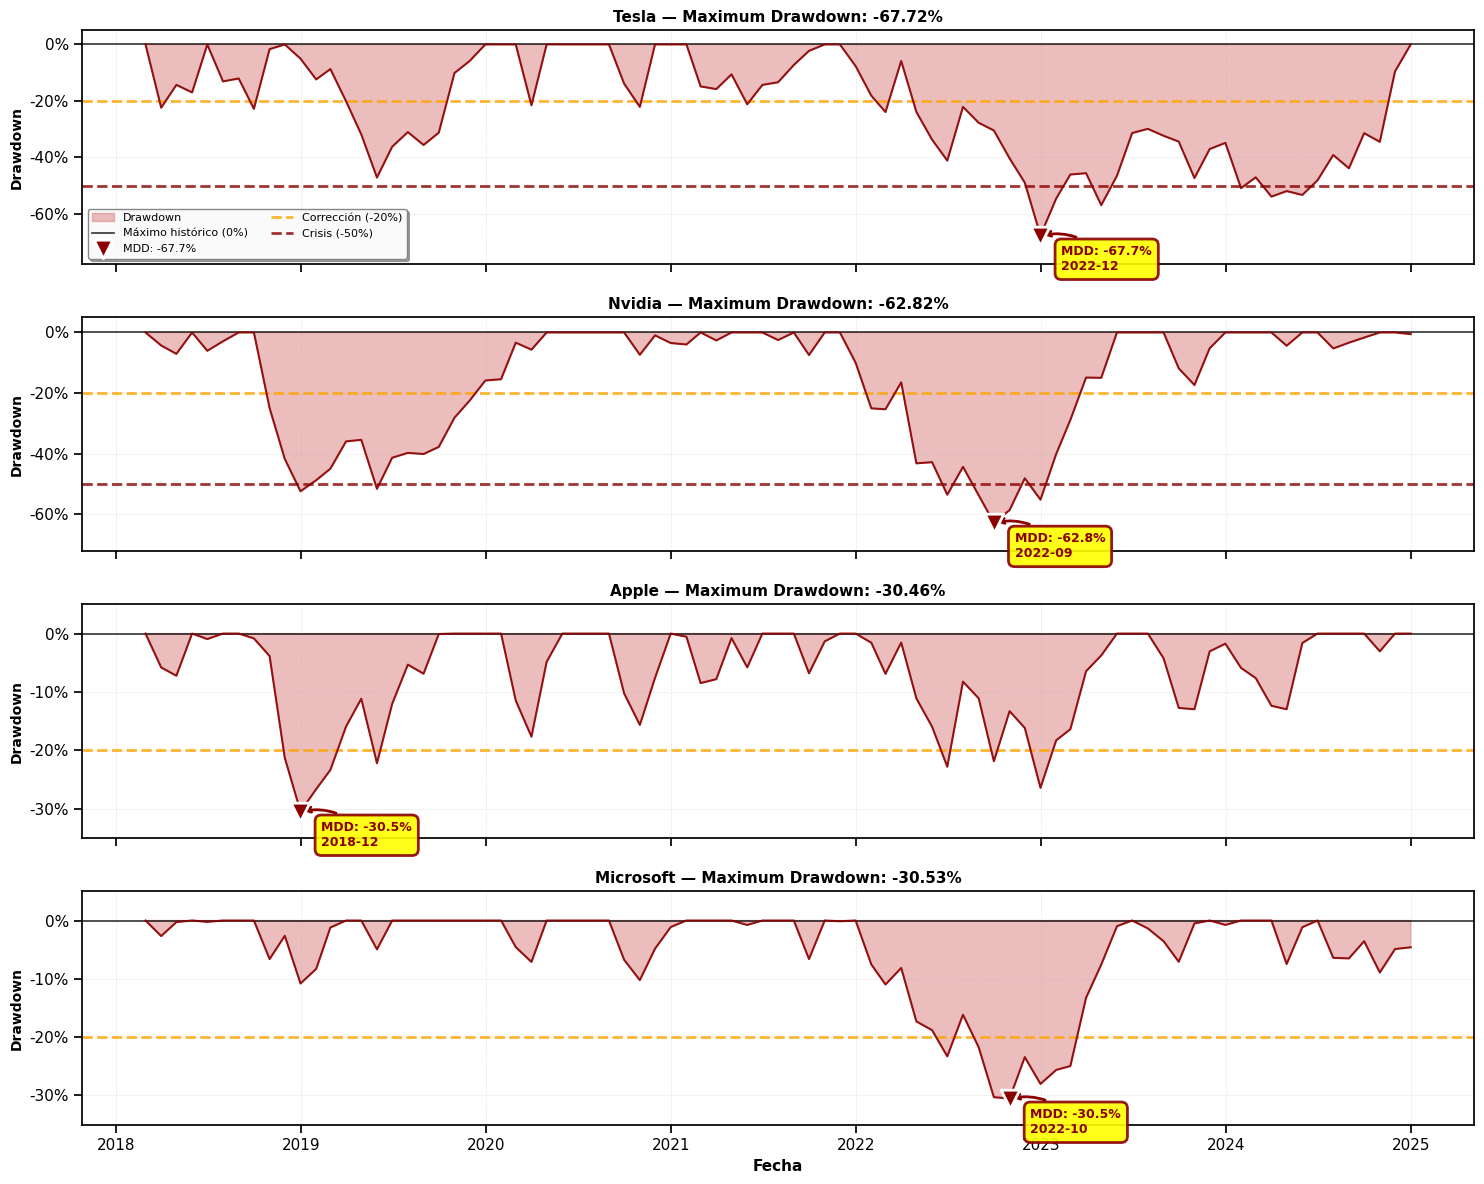

ANÁLISIS POR EMPRESA

Tesla:
  - MDD: -67.72%
  - Tiempo bajo agua: 67 meses (80.7% del periodo)
  - Retorno requerido para recuperación: 209.8%

Nvidia:
  - MDD: -62.82%
  - Tiempo bajo agua: 54 meses (65.1% del periodo)
  - Retorno requerido para recuperación: 169.0%

Apple:
  - MDD: -30.46%
  - Tiempo bajo agua: 56 meses (67.5% del periodo)
  - Retorno requerido para recuperación: 43.8%

Microsoft:
  - MDD: -30.53%
  - Tiempo bajo agua: 48 meses (57.8% del periodo)
  - Retorno requerido para recuperación: 43.9%


In [340]:
# ============================================
# Visualización de Drawdown: Series Temporales
# ============================================

empresas_plot = ["Tesla", "Nvidia", "Apple", "Microsoft"]

fig, axes = plt.subplots(len(empresas_plot), 1, figsize=(15, 12), sharex=True)

for idx, (ax, empresa) in enumerate(zip(axes, empresas_plot)):
    df_emp = panel_df[panel_df["Company"] == empresa].sort_values("Date")
    df_emp = df_emp.set_index("Date")
    
    dd = calcular_drawdown(df_emp["AdjClose"])
    
    # Área de drawdown (un solo color rojo)
    ax.fill_between(
        dd.index, 
        dd.values,
        0,
        where=(dd < 0),
        interpolate=True,
        color='indianred', 
        alpha=0.4,
        label='Drawdown' if idx == 0 else ''
    )
    
    # Línea de drawdown
    ax.plot(dd.index, dd.values, color='darkred', linewidth=1.5, alpha=0.9, zorder=3)
    
    # Línea de referencia en 0
    ax.axhline(y=0, color='black', linewidth=1.2, linestyle='-', alpha=0.8, 
               label='Máximo histórico (0%)' if idx == 0 else '')
    
    # Identificar y marcar el punto de Maximum Drawdown
    min_idx = dd.idxmin()
    min_val = dd.min()
    
    ax.scatter(
        [min_idx], 
        [min_val], 
        color='darkred', 
        s=180, 
        zorder=5,
        marker='v',
        edgecolors='white',
        linewidths=2,
        label=f'MDD: {min_val:.1%}'
    )
    
    ax.annotate(
        f'MDD: {min_val:.1%}\n{min_idx.strftime("%Y-%m")}',
        xy=(min_idx, min_val),
        xytext=(15, -25),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        color='darkred',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.9, edgecolor='darkred', linewidth=2),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='darkred', lw=2)
    )
    
    # Líneas de referencia para niveles de severidad
    ax.axhline(y=-0.20, color='orange', linestyle='--', alpha=0.8, linewidth=2, 
               label='Corrección (-20%)' if idx == 0 else '')
    ax.axhline(y=-0.50, color='darkred', linestyle='--', alpha=0.8, linewidth=2, 
               label='Crisis (-50%)' if idx == 0 else '')
    
    # Configuración del subplot
    ax.set_ylabel("Drawdown", fontsize=10, fontweight='bold')
    ax.set_title(f"{empresa} — Maximum Drawdown: {min_val:.2%}", fontsize=11, fontweight='bold')
    ax.set_ylim(min(dd) * 1.15, 0.05)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    # Leyenda solo en el primer subplot
    if idx == 0:
        ax.legend(loc='lower left', fontsize=8, framealpha=0.95, ncol=2, 
                  edgecolor='gray', fancybox=True, shadow=True)

plt.xlabel("Fecha", fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig("../data/processed/drawdown_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

# Interpretación de resultados
print("=" * 90)
print("ANÁLISIS POR EMPRESA")
print("=" * 90)

for empresa in empresas_plot:
    df_emp = panel_df[panel_df["Company"] == empresa].sort_values("Date")
    dd = calcular_drawdown(df_emp["AdjClose"])
    mdd = dd.min()
    time_uw = (dd < 0).sum()
    pct_uw = (dd < 0).sum() / len(dd) * 100
    retorno_req = (1 / (1 + mdd)) - 1
    
    print(f"\n{empresa}:")
    print(f"  - MDD: {mdd:.2%}")
    print(f"  - Tiempo bajo agua: {time_uw} meses ({pct_uw:.1f}% del periodo)")
    print(f"  - Retorno requerido para recuperación: {retorno_req:.1%}")


## Matriz de Correlación entre Activos

La correlación entre activos es un concepto fundamental en la teoría moderna de portafolios. Mide la relación lineal entre los rendimientos de dos activos y es crucial para la construcción de carteras eficientes y la gestión de riesgo.

**Coeficiente de correlación de Pearson:**

La correlación entre dos activos i y j se define como:

```
ρ_ij = Cov(R_i, R_j) / (σ_i · σ_j)
```

donde:
- Cov(R_i, R_j) es la covarianza entre los retornos de los activos i y j
- σ_i y σ_j son las desviaciones estándar de los retornos

**Interpretación:**
- ρ = +1: Correlación positiva perfecta (los activos se mueven en la misma dirección)
- ρ = 0: Sin correlación lineal (movimientos independientes)
- ρ = -1: Correlación negativa perfecta (los activos se mueven en direcciones opuestas)

**Importancia en construcción de portafolios (Markowitz, 1952):**

La teoría moderna de portafolios establece que combinar activos con correlación menor a 1 reduce el riesgo total del portafolio. Para un portafolio de dos activos:

```
σ_p² = w₁²σ₁² + w₂²σ₂² + 2w₁w₂σ₁σ₂ρ₁₂
```

El beneficio de la diversificación aumenta cuando ρ₁₂ disminuye. Activos con baja o negativa correlación proporcionan mayor reducción de riesgo.

**Referencias:**
- Markowitz, H. (1952). "Portfolio Selection". *Journal of Finance*, 7(1), 77-91.
- Elton, E.J. & Gruber, M.J. (1997). *Modern Portfolio Theory and Investment Analysis*. Wiley.

## 9. Análisis por Períodos: Pre/Post COVID-19

### 9.1 Fundamento Teórico: Análisis de Régimen

Los mercados financieros operan en diferentes **regímenes** caracterizados por distintos niveles de volatilidad, correlación y comportamiento de los retornos. La literatura académica identifica que eventos macroeconómicos significativos pueden causar **cambios estructurales** (structural breaks) en las series temporales financieras.

#### Teoría de Cambio de Régimen (Regime Switching)

Hamilton (1989) introdujo los modelos de cambio de régimen Markoviano para capturar transiciones entre estados de mercado:

$$P(S_t = j | S_{t-1} = i) = p_{ij}$$

donde $S_t$ representa el estado del mercado (ej: baja/alta volatilidad) y $p_{ij}$ son las probabilidades de transición.

#### Eventos que Causan Cambios de Régimen

| Tipo de Evento | Ejemplo | Impacto Típico |
|----------------|---------|----------------|
| Crisis Financiera | 2008, Lehman Brothers | ↑ Volatilidad, ↑ Correlación |
| Pandemia | COVID-19 (Marzo 2020) | Shock de volatilidad, cambio en sectores |
| Política Monetaria | QE, cambios de tasas | Cambio en correlaciones |
| Geopolítico | Guerra, sanciones | Volatilidad sectorial |

#### COVID-19 como Punto de Quiebre Estructural

La pandemia de COVID-19 representa un evento ideal para análisis de régimen porque:

1. **Fecha precisa**: El shock de mercado comenzó claramente en Marzo 2020
2. **Impacto universal**: Afectó a todos los sectores y geografías
3. **Cambio estructural**: Aceleró tendencias (digitalización, trabajo remoto)
4. **Intervención sin precedentes**: Estímulos fiscales y monetarios masivos

**Hipótesis a Contrastar:**
- $H_0$: Los parámetros (media, volatilidad) son iguales pre y post COVID
- $H_1$: Existe un cambio estructural en los parámetros

#### Referencias
- Hamilton, J.D. (1989). "A New Approach to the Economic Analysis of Nonstationary Time Series". *Econometrica*, 57(2), 357-384.
- Bai, J. & Perron, P. (2003). "Computation and analysis of multiple structural change models". *Journal of Applied Econometrics*, 18(1), 1-22.
- Zhang, D. et al. (2020). "Financial markets under the global pandemic of COVID-19". *Finance Research Letters*, 36, 101528.

In [341]:
# ============================================
# Análisis Comparativo Pre/Post COVID-19
# ============================================

# Definir fecha de inicio del impacto COVID en mercados
COVID_START = pd.Timestamp("2020-03-01")

# Dividir el dataset en períodos
pre_covid = panel_df[panel_df["Date"] < COVID_START].copy()
post_covid = panel_df[panel_df["Date"] >= COVID_START].copy()

print("=" * 80)
print("DIVISIÓN DE PERÍODOS")
print("=" * 80)
print(f"Período Pre-COVID:  {pre_covid['Date'].min().strftime('%Y-%m-%d')} a {pre_covid['Date'].max().strftime('%Y-%m-%d')}")
print(f"Período Post-COVID: {post_covid['Date'].min().strftime('%Y-%m-%d')} a {post_covid['Date'].max().strftime('%Y-%m-%d')}")
print(f"\nObservaciones Pre-COVID:  {len(pre_covid):,}")
print(f"Observaciones Post-COVID: {len(post_covid):,}")

# Calcular estadísticos por período para cada empresa
stats_comparison = []

for company in panel_df["Company"].unique():
    ret_pre = pre_covid[pre_covid["Company"] == company]["Return"].dropna()
    ret_post = post_covid[post_covid["Company"] == company]["Return"].dropna()
    
    # Evitar divisiones por cero
    vol_pre = ret_pre.std() if len(ret_pre) > 1 else np.nan
    vol_post = ret_post.std() if len(ret_post) > 1 else np.nan
    
    stats_comparison.append({
        "Company": company,
        "Mean_Pre": ret_pre.mean() * 100,  # En porcentaje
        "Mean_Post": ret_post.mean() * 100,
        "Vol_Pre": vol_pre * 100,
        "Vol_Post": vol_post * 100,
        "Sharpe_Pre": (ret_pre.mean() / vol_pre) if vol_pre > 0 else np.nan,
        "Sharpe_Post": (ret_post.mean() / vol_post) if vol_post > 0 else np.nan,
        "Change_Mean": (ret_post.mean() - ret_pre.mean()) * 100,
        "Change_Vol": (vol_post - vol_pre) * 100 if not np.isnan(vol_pre) and not np.isnan(vol_post) else np.nan
    })

stats_df = pd.DataFrame(stats_comparison)

# Ordenar por cambio en retorno medio
stats_df = stats_df.sort_values("Change_Mean", ascending=True)

print("\n" + "=" * 80)
print("RESUMEN ESTADÍSTICO: CAMBIOS PRE vs POST COVID")
print("=" * 80)
print(f"\nEmpresas con MEJOR rendimiento post-COVID:")
top_performers = stats_df.nlargest(5, "Change_Mean")[["Company", "Mean_Pre", "Mean_Post", "Change_Mean"]]
print(top_performers.to_string(index=False))

print(f"\nEmpresas con PEOR rendimiento post-COVID:")
bottom_performers = stats_df.nsmallest(5, "Change_Mean")[["Company", "Mean_Pre", "Mean_Post", "Change_Mean"]]
print(bottom_performers.to_string(index=False))

DIVISIÓN DE PERÍODOS
Período Pre-COVID:  2018-02-28 a 2020-02-29
Período Post-COVID: 2020-03-31 a 2024-12-31

Observaciones Pre-COVID:  677
Observaciones Post-COVID: 1,726

RESUMEN ESTADÍSTICO: CAMBIOS PRE vs POST COVID

Empresas con MEJOR rendimiento post-COVID:
 Company  Mean_Pre  Mean_Post  Change_Mean
  Nvidia  0.405781   5.202302     4.796521
Broadcom  0.712130   3.962108     3.249978
 Spotify -0.748640   2.055795     2.804435
  Oracle -0.034992   2.222440     2.257432
     IBM -0.511492   1.367675     1.879168

Empresas con PEOR rendimiento post-COVID:
   Company  Mean_Pre  Mean_Post  Change_Mean
     Intel  0.788149  -1.568112    -2.356262
     Adobe  2.187102   0.441342    -1.745760
ServiceNow  3.136400   2.044980    -1.091420
   Workday  1.472644   0.713119    -0.759525
 Microsoft  2.272979   1.734126    -0.538853


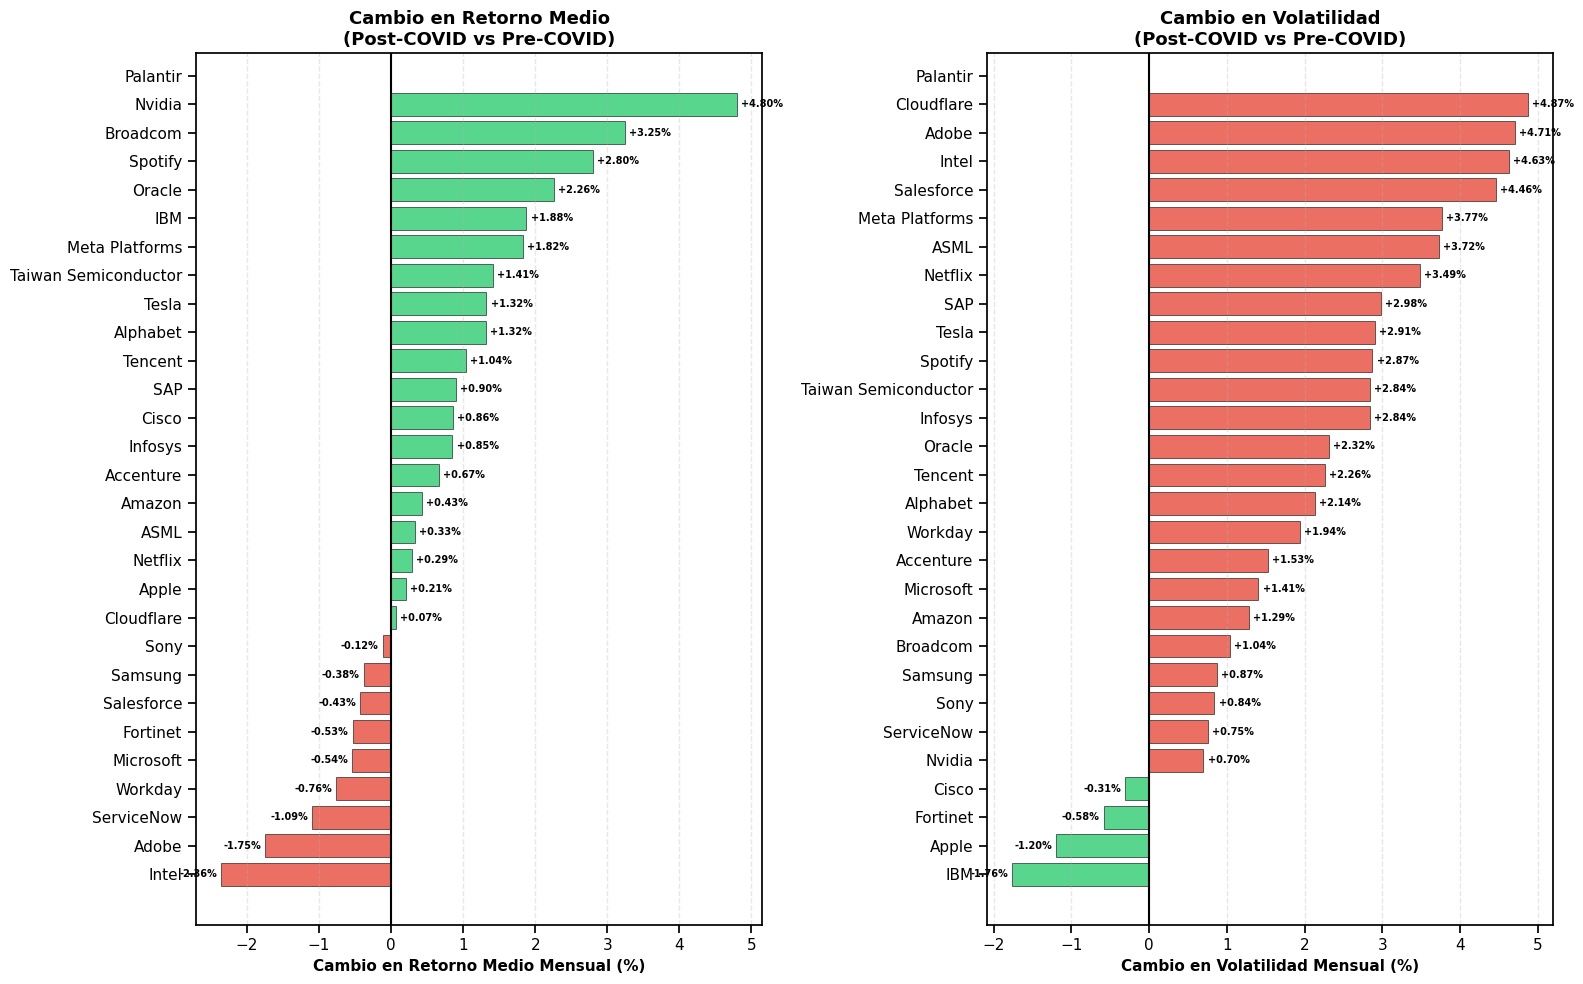


INTERPRETACIÓN

• 19 de 30 empresas (63.3%) mejoraron su retorno medio post-COVID
• 24 de 30 empresas (80.0%) aumentaron su volatilidad post-COVID

• Verde en retorno = Mejora (mayor retorno post-COVID)
• Rojo en retorno = Deterioro (menor retorno post-COVID)
• Verde en volatilidad = Mejora (menor volatilidad post-COVID)
• Rojo en volatilidad = Deterioro (mayor volatilidad post-COVID)


In [342]:
# ============================================
# Visualización: Cambios en Retorno y Volatilidad
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Ordenar para mejor visualización
stats_sorted = stats_df.sort_values("Change_Mean", ascending=True)

# --- Panel 1: Cambio en Retorno Medio ---
colors_mean = ['#2ecc71' if x > 0 else '#e74c3c' for x in stats_sorted["Change_Mean"]]
bars1 = axes[0].barh(stats_sorted["Company"], stats_sorted["Change_Mean"], 
                      color=colors_mean, alpha=0.8, edgecolor='black', linewidth=0.5)
axes[0].axvline(x=0, color='black', linewidth=1.5, linestyle='-')
axes[0].set_xlabel("Cambio en Retorno Medio Mensual (%)", fontsize=11, fontweight='bold')
axes[0].set_title("Cambio en Retorno Medio\n(Post-COVID vs Pre-COVID)", fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x', linestyle='--')

# Añadir valores en las barras
for bar, val in zip(bars1, stats_sorted["Change_Mean"]):
    width = bar.get_width()
    axes[0].annotate(f'{val:+.2f}%',
                     xy=(width, bar.get_y() + bar.get_height()/2),
                     xytext=(3 if width >= 0 else -3, 0),
                     textcoords="offset points",
                     ha='left' if width >= 0 else 'right',
                     va='center', fontsize=7, fontweight='bold')

# --- Panel 2: Cambio en Volatilidad ---
stats_sorted_vol = stats_df.sort_values("Change_Vol", ascending=True)
colors_vol = ['#e74c3c' if x > 0 else '#2ecc71' for x in stats_sorted_vol["Change_Vol"]]
bars2 = axes[1].barh(stats_sorted_vol["Company"], stats_sorted_vol["Change_Vol"], 
                      color=colors_vol, alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1].axvline(x=0, color='black', linewidth=1.5, linestyle='-')
axes[1].set_xlabel("Cambio en Volatilidad Mensual (%)", fontsize=11, fontweight='bold')
axes[1].set_title("Cambio en Volatilidad\n(Post-COVID vs Pre-COVID)", fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x', linestyle='--')

# Añadir valores en las barras
for bar, val in zip(bars2, stats_sorted_vol["Change_Vol"]):
    if not np.isnan(val):
        width = bar.get_width()
        axes[1].annotate(f'{val:+.2f}%',
                         xy=(width, bar.get_y() + bar.get_height()/2),
                         xytext=(3 if width >= 0 else -3, 0),
                         textcoords="offset points",
                         ha='left' if width >= 0 else 'right',
                         va='center', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.savefig("../data/processed/covid_period_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Interpretación
print("\n" + "=" * 80)
print("INTERPRETACIÓN")
print("=" * 80)
n_better_return = (stats_df["Change_Mean"] > 0).sum()
n_higher_vol = (stats_df["Change_Vol"] > 0).sum()
print(f"\n• {n_better_return} de {len(stats_df)} empresas ({n_better_return/len(stats_df)*100:.1f}%) mejoraron su retorno medio post-COVID")
print(f"• {n_higher_vol} de {len(stats_df)} empresas ({n_higher_vol/len(stats_df)*100:.1f}%) aumentaron su volatilidad post-COVID")
print(f"\n• Verde en retorno = Mejora (mayor retorno post-COVID)")
print(f"• Rojo en retorno = Deterioro (menor retorno post-COVID)")
print(f"• Verde en volatilidad = Mejora (menor volatilidad post-COVID)")
print(f"• Rojo en volatilidad = Deterioro (mayor volatilidad post-COVID)")

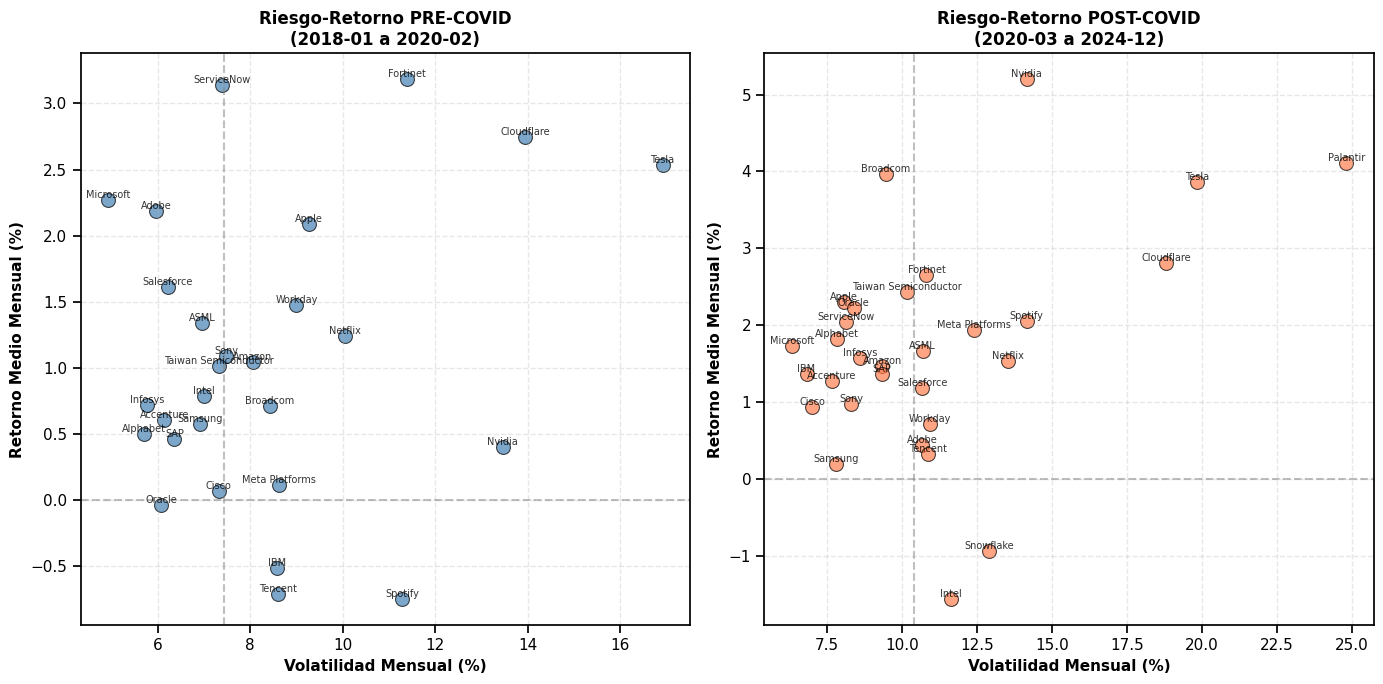


ANÁLISIS DE LA RELACIÓN RIESGO-RETORNO POR PERÍODO

PRE-COVID:
  • Retorno medio promedio: 1.07%
  • Volatilidad promedio: 8.40%
  • Correlación Riesgo-Retorno: 0.231

POST-COVID:
  • Retorno medio promedio: 1.72%
  • Volatilidad promedio: 11.01%
  • Correlación Riesgo-Retorno: 0.425


In [343]:
# ============================================
# Visualización: Scatter Plot Riesgo-Retorno por Período
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Panel 1: Pre-COVID
axes[0].scatter(stats_df["Vol_Pre"], stats_df["Mean_Pre"], 
                s=100, alpha=0.7, c='steelblue', edgecolors='black', linewidth=0.8)
for i, row in stats_df.iterrows():
    axes[0].annotate(row["Company"], (row["Vol_Pre"], row["Mean_Pre"]), 
                     fontsize=7, alpha=0.8, ha='center', va='bottom')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(x=stats_df["Vol_Pre"].median(), color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel("Volatilidad Mensual (%)", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Retorno Medio Mensual (%)", fontsize=11, fontweight='bold')
axes[0].set_title("Riesgo-Retorno PRE-COVID\n(2018-01 a 2020-02)", fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Panel 2: Post-COVID
axes[1].scatter(stats_df["Vol_Post"], stats_df["Mean_Post"], 
                s=100, alpha=0.7, c='coral', edgecolors='black', linewidth=0.8)
for i, row in stats_df.iterrows():
    axes[1].annotate(row["Company"], (row["Vol_Post"], row["Mean_Post"]), 
                     fontsize=7, alpha=0.8, ha='center', va='bottom')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(x=stats_df["Vol_Post"].median(), color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel("Volatilidad Mensual (%)", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Retorno Medio Mensual (%)", fontsize=11, fontweight='bold')
axes[1].set_title("Riesgo-Retorno POST-COVID\n(2020-03 a 2024-12)", fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig("../data/processed/risk_return_periods.png", dpi=150, bbox_inches='tight')
plt.show()

# Análisis de dispersión
print("\n" + "=" * 80)
print("ANÁLISIS DE LA RELACIÓN RIESGO-RETORNO POR PERÍODO")
print("=" * 80)
print(f"\nPRE-COVID:")
print(f"  • Retorno medio promedio: {stats_df['Mean_Pre'].mean():.2f}%")
print(f"  • Volatilidad promedio: {stats_df['Vol_Pre'].mean():.2f}%")
print(f"  • Correlación Riesgo-Retorno: {stats_df['Vol_Pre'].corr(stats_df['Mean_Pre']):.3f}")

print(f"\nPOST-COVID:")
print(f"  • Retorno medio promedio: {stats_df['Mean_Post'].mean():.2f}%")
print(f"  • Volatilidad promedio: {stats_df['Vol_Post'].mean():.2f}%")
print(f"  • Correlación Riesgo-Retorno: {stats_df['Vol_Post'].corr(stats_df['Mean_Post']):.3f}")

In [344]:
# ============================================
# Test Estadístico: Comparación de Medias (Welch's t-test)
# ============================================

from scipy.stats import ttest_ind, levene

print("=" * 90)
print("TESTS ESTADÍSTICOS: COMPARACIÓN PRE vs POST COVID")
print("=" * 90)
print("\nTest de Welch (t-test para varianzas desiguales) - H0: μ_pre = μ_post")
print("Test de Levene (homogeneidad de varianzas) - H0: σ²_pre = σ²_post")
print("-" * 90)

test_results = []

for company in panel_df["Company"].unique():
    ret_pre = pre_covid[pre_covid["Company"] == company]["Return"].dropna()
    ret_post = post_covid[post_covid["Company"] == company]["Return"].dropna()
    
    if len(ret_pre) > 2 and len(ret_post) > 2:
        # Welch's t-test (no asume varianzas iguales)
        t_stat, t_pval = ttest_ind(ret_pre, ret_post, equal_var=False)
        
        # Levene test para varianzas
        l_stat, l_pval = levene(ret_pre, ret_post)
        
        test_results.append({
            "Company": company,
            "t_stat": t_stat,
            "t_pval": t_pval,
            "Mean_Diff_Signif": "Sí" if t_pval < 0.05 else "No",
            "l_stat": l_stat,
            "l_pval": l_pval,
            "Var_Diff_Signif": "Sí" if l_pval < 0.05 else "No"
        })

test_df = pd.DataFrame(test_results)

# Mostrar empresas con diferencias significativas
signif_mean = test_df[test_df["Mean_Diff_Signif"] == "Sí"]
signif_var = test_df[test_df["Var_Diff_Signif"] == "Sí"]

print(f"\nEmpresas con CAMBIO SIGNIFICATIVO en media (α=0.05): {len(signif_mean)} de {len(test_df)}")
if len(signif_mean) > 0:
    print(signif_mean[["Company", "t_stat", "t_pval"]].to_string(index=False))

print(f"\nEmpresas con CAMBIO SIGNIFICATIVO en varianza (α=0.05): {len(signif_var)} de {len(test_df)}")
if len(signif_var) > 0:
    print(signif_var[["Company", "l_stat", "l_pval"]].head(10).to_string(index=False))
    if len(signif_var) > 10:
        print(f"... y {len(signif_var) - 10} más")

print("\n" + "=" * 90)
print("CONCLUSIÓN DEL ANÁLISIS DE RÉGIMEN")
print("=" * 90)
pct_mean_change = len(signif_mean) / len(test_df) * 100
pct_var_change = len(signif_var) / len(test_df) * 100
print(f"\n• {pct_mean_change:.1f}% de empresas muestran cambio estadísticamente significativo en retorno medio")
print(f"• {pct_var_change:.1f}% de empresas muestran cambio estadísticamente significativo en volatilidad")
print(f"\n→ El COVID-19 representó un punto de quiebre estructural para {'la mayoría' if pct_var_change > 50 else 'algunas'} de las empresas del sector tecnológico.")

TESTS ESTADÍSTICOS: COMPARACIÓN PRE vs POST COVID

Test de Welch (t-test para varianzas desiguales) - H0: μ_pre = μ_post
Test de Levene (homogeneidad de varianzas) - H0: σ²_pre = σ²_post
------------------------------------------------------------------------------------------

Empresas con CAMBIO SIGNIFICATIVO en media (α=0.05): 0 de 28

Empresas con CAMBIO SIGNIFICATIVO en varianza (α=0.05): 3 de 28
   Company    l_stat   l_pval
      ASML  4.673014 0.033592
Salesforce  6.511481 0.012598
     Adobe 10.404798 0.001814

CONCLUSIÓN DEL ANÁLISIS DE RÉGIMEN

• 0.0% de empresas muestran cambio estadísticamente significativo en retorno medio
• 10.7% de empresas muestran cambio estadísticamente significativo en volatilidad

→ El COVID-19 representó un punto de quiebre estructural para algunas de las empresas del sector tecnológico.
